In [ ]:
"""
Ï∞∏Í≥† GitHub
https://github.com/DeepGraphLearning/RecommenderSystems/blob/master/featureRec/autoint/model.py 
"""

In [1]:
import pandas as pd
import numpy as np
import os
import config
from sklearn.model_selection import KFold
from sklearn import preprocessing 

In [2]:
# pre-processing
import pandas as pd
import numpy as np
import os

def safe_divide(numerator, denominator, default=0.0):
    """ÏïàÏ†ÑÌïú ÎÇòÎàóÏÖà Ìó¨Ìçº Ìï®Ïàò"""
    if denominator > 0:
        return numerator / denominator
    return default

class DataPreprocessor:
    def __init__(self, chair_path, person_path, output_dir):
        self.chair_path = chair_path
        self.person_path = person_path
        self.output_dir = output_dir
        
        # ÏÇ¨Ïö©Ìï† Chair ÌîºÏ≤ò Ï†ïÏùò
        self.categorical_features = [
            'Ìó§ÎìúÎ†àÏä§Ìä∏ Ïú†Î¨¥', 'ÌåîÍ±∏Ïù¥ Ïú†Î¨¥', 'ÏöîÏ∂îÏßÄÏßÄÎåÄ Ïú†Î¨¥', 
            'ÎÜíÏù¥ Ï°∞Ï†à Î†àÎ≤Ñ Ïú†Î¨¥', 'Ìã∏ÌåÖ Ïó¨Î∂Ä', 'Îì±Î∞õÏù¥ Í≥ß/Í∫æ'
        ]
        
        self.numerical_features = [
            'h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN', 'h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX',
            'b3_Ï¢åÏÑù Í∞ÄÎ°ú Í∏∏Ïù¥', 't4_Ï¢åÏÑù ÏÑ∏Î°ú Í∏∏Ïù¥ ÏùºÎ∞ò',
            'b4_Îì±Î∞õÏù¥ Í∞ÄÎ°ú Í∏∏Ïù¥', 'h7_Îì±Î∞õÏù¥ ÏÑ∏Î°ú Í∏∏Ïù¥'
        ]
        
        # Person Îç∞Ïù¥ÌÑ∞Ïùò ÌîºÏ≤ò (cm -> mm Î≥ÄÌôò ÌïÑÏöî)
        self.person_features = [
            'human-height', 'A_Buttock-popliteal length',
            'B_Popliteal-height', 'C_Hip-breadth',
            'F_Sitting-height', 'G_Shoulder-breadth'
        ]
        
        os.makedirs(output_dir, exist_ok=True)

    def load_data(self):
        """Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨"""
        # Chair Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        self.chair_df = pd.read_excel(self.chair_path, engine='openpyxl')
        
        # Person Îç∞Ïù¥ÌÑ∞ Î°úÎìú (cm -> mm Î≥ÄÌôò)
        self.person_df = pd.read_csv(self.person_path, encoding='utf-8')
        for col in self.person_features:
            if col in self.person_df.columns:
                self.person_df[col] *= 10  # cm to mm
        
        # Î≤îÏ£ºÌòï ÌîºÏ≤ò Ï†ÑÏ≤òÎ¶¨
        for col in self.categorical_features:
            if col in self.chair_df.columns:
                if col == 'Îì±Î∞õÏù¥ Í≥ß/Í∫æ':
                    # 'Í≥ß'=0, 'Í∫æ'=1Î°ú Îß§Ìïë
                    self.chair_df[col] = self.chair_df[col].map({'Í≥ß': 0, 'Í∫æ': 1})
                else:
                    # 'O'=1, 'X'=0ÏúºÎ°ú Îß§Ìïë
                    self.chair_df[col] = self.chair_df[col].map({'O': 1, 'X': 0})
        
        # Í≤∞Ï∏°Í∞í Ï≤òÎ¶¨
        # ÎÜíÏù¥ Ï°∞Ï†à Î≤îÏúÑÍ∞Ä ÏóÜÎäî Í≤ΩÏö∞ -> MAX = MIN
        # Í∑∏ Ïô∏ Î≤îÏ£ºÌòï Ïª¨ÎüºÏùÄ 0, ÏàòÏπòÌòï Ïª¨ÎüºÏùÄ ÌèâÍ∑†Í∞íÏúºÎ°ú ÎåÄÏ≤¥
        self.chair_df['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'] = np.where(pd.isna(self.chair_df['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']),
                                                        self.chair_df['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'],
                                                        self.chair_df['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'])
        self.chair_df[self.categorical_features] = self.chair_df[self.categorical_features].fillna(0)
        self.chair_df[self.numerical_features] = self.chair_df[self.numerical_features].fillna(self.chair_df[self.numerical_features].mean())
    
    def create_feature_mappings(self):
        """ÌîºÏ≤ò Ïù∏Îç±Ïä§ Îß§Ìïë ÏÉùÏÑ±"""
        # ÏàòÏπòÌòï ÌîºÏ≤ò Ïù∏Îç±Ïä§ (1Î∂ÄÌÑ∞ ÏãúÏûë)
        self.feature_idx_map = {}
        idx = 1
        
        # Person ÌîºÏ≤ò (6Í∞ú)
        for feat in self.person_features:
            self.feature_idx_map[f'person_{feat}'] = idx
            idx += 1
        
        # Chair ÏàòÏπòÌòï ÌîºÏ≤ò (6Í∞ú)
        for feat in self.numerical_features:
            self.feature_idx_map[f'chair_{feat}'] = idx
            idx += 1
        
        # ÏÉÅÌò∏ÏûëÏö© ÌîºÏ≤ò (6Í∞ú Ï∂îÍ∞Ä)
        interaction_features = [
            'height_match_score', 'width_margin_ratio', 'depth_margin_ratio',
            'backrest_height_ratio', 'shoulder_width_ratio', 'adjustable_range'
        ]
        for feat in interaction_features:
            self.feature_idx_map[feat] = idx
            idx += 1
        
        # Ïù¥ÏßÑ Î≤îÏ£ºÌòï ÌîºÏ≤ò ÏãúÏûë Ïò§ÌîÑÏÖã
        self.binary_offset = idx
        
        # Ïù¥ÏßÑ ÌîºÏ≤ò Ïù∏Îç±Ïä§ (Í∞Å ÌîºÏ≤òÎãπ 2Í∞úÏî©: 0Í≥º 1)
        for i, feat in enumerate(self.categorical_features):
            # Í∞Å Ïù¥ÏßÑ ÌîºÏ≤òÎäî 2Í∞úÏùò ÏûÑÎ≤†Îî©ÏùÑ Í∞ÄÏßê (0 ÎòêÎäî 1)
            self.feature_idx_map[f'{feat}_0'] = self.binary_offset + i * 2
            self.feature_idx_map[f'{feat}_1'] = self.binary_offset + i * 2 + 1
        
        print(f"Total number of features: {len(self.feature_idx_map)}")
        print(f"Numerical features: {self.binary_offset - 1}")
        print(f"Binary categorical embeddings: {len(self.categorical_features) * 2}")

    def calculate_interaction_features(self, person_row, chair_row):
        """PersonÍ≥º Chair Í∞ÑÏùò ÏÉÅÌò∏ÏûëÏö© ÌîºÏ≤ò Í≥ÑÏÇ∞"""
        features = {}
        
        # ÎÜíÏù¥ Ï†ÅÌï©ÎèÑ (Ï°∞Ï†à Î≤îÏúÑ ÎÇ¥Ïóê ÏûàÎäîÏßÄ)
        h8_mid = (chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] + chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']) / 2
        h8_range = chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'] - chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']
        popliteal_height = person_row['B_Popliteal-height']
        
        if h8_range > 0:
            # Ï°∞Ï†à Í∞ÄÎä•Ìïú Í≤ΩÏö∞
            if chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] <= popliteal_height <= chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']:
                features['height_match_score'] = 1.0
            else:
                # Î≤îÏúÑ Î∞ñÏù∏ Í≤ΩÏö∞ Í±∞Î¶¨Ïóê Îî∞Îùº Ï†êÏàò Í∞êÏÜå
                if popliteal_height < chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']:
                    dist = chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] - popliteal_height
                else:
                    dist = popliteal_height - chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']
                features['height_match_score'] = max(0, 1 - dist / 100)  # 100mmÎãπ 1Ï†ê Í∞êÏÜå
        else:
            # Í≥†Ï†ï ÎÜíÏù¥Ïù∏ Í≤ΩÏö∞
            features['height_match_score'] = max(0, 1 - abs(h8_mid - popliteal_height) / 50)
        
        # ÏïàÏ†ÑÌïú ÎÇòÎàóÏÖà ÏÇ¨Ïö©
        # ÎÑàÎπÑ Ïó¨Ïú†Ïú®
        features['width_margin_ratio'] = safe_divide(
            chair_row['b3_Ï¢åÏÑù Í∞ÄÎ°ú Í∏∏Ïù¥'] - person_row['C_Hip-breadth'], 
            person_row['C_Hip-breadth']
        )
        # ÍπäÏù¥ Ïó¨Ïú†Ïú®
        features['depth_margin_ratio'] = safe_divide(
            person_row['A_Buttock-popliteal length'] - chair_row['t4_Ï¢åÏÑù ÏÑ∏Î°ú Í∏∏Ïù¥ ÏùºÎ∞ò'], 
            person_row['A_Buttock-popliteal length']
        )
        # Îì±Î∞õÏù¥ ÎÜíÏù¥ ÎπÑÏú®
        features['backrest_height_ratio'] = safe_divide(
            chair_row['h7_Îì±Î∞õÏù¥ ÏÑ∏Î°ú Í∏∏Ïù¥'], 
            person_row['F_Sitting-height']
        )
        # Ïñ¥Íπ® ÎÑàÎπÑ ÎπÑÏú®
        features['shoulder_width_ratio'] = safe_divide(
            chair_row['b4_Îì±Î∞õÏù¥ Í∞ÄÎ°ú Í∏∏Ïù¥'], 
            person_row['G_Shoulder-breadth']
        )
        # Ï°∞Ï†à Í∞ÄÎä• Î≤îÏúÑ
        features['adjustable_range'] = h8_range
        
        return features
    
    def check_matching_conditions(self, person_row, chair_row):
        """ÌïÑÏàò Îß§Ïπ≠ Ï°∞Í±¥ ÌôïÏù∏ Î∞è Î†àÏù¥Î∏î ÏÉùÏÑ±"""
        conditions = {
            't4 < A': chair_row['t4_Ï¢åÏÑù ÏÑ∏Î°ú Í∏∏Ïù¥ ÏùºÎ∞ò'] < person_row['A_Buttock-popliteal length'],
            'h8 ‚âà B': (chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] <= person_row['B_Popliteal-height'] <= chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']) 
                      if chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'] > chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']
                      else abs((chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] + chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'])/2 - person_row['B_Popliteal-height']) < 50,
            'b3 > C': chair_row['b3_Ï¢åÏÑù Í∞ÄÎ°ú Í∏∏Ïù¥'] > person_row['C_Hip-breadth'],
            'h7 < F': chair_row['h7_Îì±Î∞õÏù¥ ÏÑ∏Î°ú Í∏∏Ïù¥'] < person_row['F_Sitting-height'],
            'b4 ‚â• G': chair_row['b4_Îì±Î∞õÏù¥ Í∞ÄÎ°ú Í∏∏Ïù¥'] >= person_row['G_Shoulder-breadth']
        }
        
        # Î™®Îì† Ï°∞Í±¥ ÎßåÏ°± Ïãú 1, ÏïÑÎãàÎ©¥ 0
        all_satisfied = all(conditions.values())
        
        # Soft label: ÎßåÏ°±ÌïòÎäî Ï°∞Í±¥ Ïàò / Ï†ÑÏ≤¥ Ï°∞Í±¥ Ïàò
        soft_label = sum(conditions.values()) / len(conditions)
        
        return int(all_satisfied), soft_label, conditions
    
    def process_data(self):
        """Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ Î∞è ÌååÏùº ÏÉùÏÑ±"""
        self.load_data()
        self.create_feature_mappings()
        
        # Ï∂úÎ†• ÌååÏùº Ïó¥Í∏∞
        f_train_value = open(os.path.join(self.output_dir, 'train_x.txt'), 'w')
        f_train_index = open(os.path.join(self.output_dir, 'train_i.txt'), 'w')
        f_train_label = open(os.path.join(self.output_dir, 'train_y.txt'), 'w')
        
        cnt = 0
        positive_cnt = 0
        
        # Î™®Îì† Person-Chair Ï°∞Ìï© ÏÉùÏÑ±
        for _, person in self.person_df.iterrows():
            for _, chair in self.chair_df.iterrows():
                cnt += 1
                
                # ÌîºÏ≤ò Í∞íÍ≥º Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏
                values = []
                indices = []
                
                # 1. Person ÏàòÏπòÌòï ÌîºÏ≤ò
                for feat in self.person_features:
                    if feat in person.index:
                        values.append(str(person[feat]))
                        indices.append(str(self.feature_idx_map[f'person_{feat}']))
                
                # 2. Chair ÏàòÏπòÌòï ÌîºÏ≤ò
                for feat in self.numerical_features:
                    values.append(str(chair[feat]))
                    indices.append(str(self.feature_idx_map[f'chair_{feat}']))
                
                # 3. ÏÉÅÌò∏ÏûëÏö© ÌîºÏ≤ò Í≥ÑÏÇ∞
                interaction_feats = self.calculate_interaction_features(person, chair)
                for feat_name, feat_value in interaction_feats.items():
                    values.append(str(feat_value))
                    indices.append(str(self.feature_idx_map[feat_name]))
                
                # 4. Ïù¥ÏßÑ Î≤îÏ£ºÌòï ÌîºÏ≤ò (Í∞íÏùÄ 1, Ïù∏Îç±Ïä§Îäî 0 ÎòêÎäî 1Ïóê Îî∞Îùº Îã§Î¶Ñ)
                for feat in self.categorical_features:
                    values.append('1')  # Î≤îÏ£ºÌòïÏùÄ Ìï≠ÏÉÅ 1
                    feat_value = int(chair[feat]) if not pd.isna(chair[feat]) else 0
                    idx_key = f'{feat}_{feat_value}'
                    indices.append(str(self.feature_idx_map[idx_key]))
                
                # 5. Î†àÏù¥Î∏î Í≥ÑÏÇ∞
                hard_label, soft_label, conditions = self.check_matching_conditions(person, chair)
                
                # ÌååÏùºÏóê Ïì∞Í∏∞
                f_train_value.write(' '.join(values) + '\n')
                f_train_index.write(' '.join(indices) + '\n')
                f_train_label.write(f'{soft_label:.4f}\n')  # soft label ÏÇ¨Ïö©
                
                if hard_label == 1:
                    positive_cnt += 1
                
                if cnt % 1000 == 0:
                    print(f'Processed {cnt} combinations...')
        
        f_train_value.close()
        f_train_index.close()
        f_train_label.close()
        
        print(f"\nTotal combinations: {cnt}")
        print(f"Positive matches (all conditions satisfied): {positive_cnt} ({positive_cnt/cnt*100:.2f}%)")
        
        # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        self.save_metadata()
    
    def save_metadata(self):
        """ÌîºÏ≤ò Îß§Ìïë Ï†ïÎ≥¥ Ï†ÄÏû•"""
        import json
        
        metadata = {
            'feature_mappings': self.feature_idx_map,
            'total_features': len(self.feature_idx_map),
            'numerical_features': self.binary_offset - 1,
            'categorical_features': self.categorical_features,
            'person_features': self.person_features,
            'chair_numerical_features': self.numerical_features
        }
        
        with open(os.path.join(self.output_dir, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)

In [ ]:
# Ï†ÑÏ≤òÎ¶¨ Ïã§Ìñâ
preprocessor = DataPreprocessor(
    chair_path='chair_dummy.xlsx',
    person_path='person.csv',
    output_dir='processed_data/'
)
    
preprocessor.process_data()

Total number of features: 30
Numerical features: 18
Binary categorical embeddings: 12
Processed 1000 combinations...
Processed 2000 combinations...
Processed 3000 combinations...
Processed 4000 combinations...
Processed 5000 combinations...
Processed 6000 combinations...
Processed 7000 combinations...
Processed 8000 combinations...
Processed 9000 combinations...
Processed 10000 combinations...
Processed 11000 combinations...
Processed 12000 combinations...
Processed 13000 combinations...

Total combinations: 13986
Positive matches (all conditions satisfied): 485 (3.47%)


In [4]:
# K-fold
import numpy as np
import config  # ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÏÑ§Ï†ï ÌååÏùº (Í≤ΩÎ°ú, ÏãúÎìú Îì±)
import os
import pandas as pd
from sklearn.model_selection import KFold
# from sklearn import preprocessing 

scale = ""
train_x_name = "train_x.npy"  # ÏàòÏπòÌòï ÌäπÏÑ± Ï†ÄÏû• ÌååÏùºÎ™Ö
train_y_name = "train_y.npy"  # Î†àÏù¥Î∏î Ï†ÄÏû• ÌååÏùºÎ™Ö

Column = 18  # Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏàòÏπòÌòï ÌäπÏÑ± Í∞úÏàò

def _load_data(_nrows=None, debug = False):
    """
    train_x.txtÏôÄ train_y.txt ÌååÏùºÏùÑ ÏùΩÏñ¥ Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÎäî Ìï®Ïàò
    
    Args:
        nrows: ÏùΩÏùÑ ÌñâÏùò Ïàò (NoneÏù¥Î©¥ Ï†ÑÏ≤¥ ÏùΩÍ∏∞)
        debug: ÎîîÎ≤ÑÍ∑∏ Î™®Îìú ÌîåÎûòÍ∑∏
    
    Returns:
        train_x: ÏàòÏπòÌòï ÌäπÏÑ± Î∞∞Ïó¥
        train_y: Î†àÏù¥Î∏î Î∞∞Ïó¥
    """

    # config.TRAIN_XÎäî train_x.txt ÌååÏùº Í≤ΩÎ°ú
    # Í≥µÎ∞±ÏúºÎ°ú Íµ¨Î∂ÑÎêú 18Í∞úÏùò ÏàòÏπòÌòï ÌäπÏÑ±Í∞íÏùÑ ÏùΩÏùå
    train_x = pd.read_csv(config.TRAIN_X,header=None,sep=' ',nrows=_nrows, dtype=np.float64)
    # config.TRAIN_YÎäî train_y.txt ÌååÏùº Í≤ΩÎ°ú
    # Í∞Å ÏÉòÌîåÏùò Î†àÏù¥Î∏î(0 ~ 1 ÏÇ¨Ïù¥ Í∞í)ÏùÑ ÏùΩÏùå
    train_y = pd.read_csv(config.TRAIN_Y,header=None,sep=' ',nrows=_nrows, dtype=np.float64)

    # DataFrameÏùÑ numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    train_x = train_x.values
    train_y = train_y.values.reshape([-1]) # 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú Î≥ÄÌôò
    
    print('data loading done!')
    print('training data : %d' % train_y.shape[0])
    
    # xÏôÄ yÏùò ÏÉòÌîå ÏàòÍ∞Ä ÎèôÏùºÌïúÏßÄ ÌôïÏù∏
    assert train_x.shape[0]==train_y.shape[0]

    return train_x, train_y


def save_x_y(fold_index, train_x, train_y):
    """
    10Í∞úÏùò foldÎ°ú Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞Î•º Í∞ÅÍ∞Å Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò

    Args:
        fold_index: Í∞Å foldÏóê ÏÜçÌïòÎäî ÏÉòÌîåÎì§Ïùò Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏
        train_x: Ï†ÑÏ≤¥ ÏàòÏπòÌòï ÌäπÏÑ± Îç∞Ïù¥ÌÑ∞
        train_y: Ï†ÑÏ≤¥ Î†àÏù¥Î∏î Îç∞Ïù¥ÌÑ∞
    """
    
    # Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏Î•º ÏÇ¨Ïö©Ìï¥ Ìï¥ÎãπÌïòÎäî ÏöîÏÜå(Ìñâ)Îì§ÏùÑ Ï∂îÏ∂ú
    _get = lambda x, l: [x[i] for i in l]

    for i in range(len(fold_index)):
        print("now part %d" % (i+1))
        part_index = fold_index[i] # iÎ≤àÏß∏ foldÏùò Ïù∏Îç±Ïä§Îì§

        # Ìï¥Îãπ foldÏùò Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
        Xv_train_, y_train_ = _get(train_x, part_index), _get(train_y, part_index)
        
        # Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï (part1, part2, ..., part10)
        save_dir_Xv = config.DATA_PATH +  "part" + str(i+1) + "/"
        save_dir_y = config.DATA_PATH +  "part" + str(i+1) + "/"

        # ÎîîÎ†âÌÜ†Î¶¨Í∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
        if (os.path.exists(save_dir_Xv) == False):
            os.makedirs(save_dir_Xv)
        if (os.path.exists(save_dir_y) == False):
            os.makedirs(save_dir_y)
        
        # ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï Î∞è Ï†ÄÏû•
        save_path_Xv  = save_dir_Xv + train_x_name # part*/train_x.npy
        save_path_y  = save_dir_y + train_y_name   # part*/train_y.npy
        np.save(save_path_Xv, Xv_train_)
        np.save(save_path_y, y_train_)

def save_i(fold_index):
    """
    train_i.txt ÌååÏùºÏùÑ ÏùΩÏñ¥ Î≤îÏ£ºÌòï ÌäπÏÑ± Ïù∏Îç±Ïä§Î•º foldÎ≥ÑÎ°ú Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò

    Args:
        fold_index: Í∞Å foldÏóê ÏÜçÌïòÎäî ÏÉòÌîåÎì§Ïùò Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏
    """

    _get = lambda x, l: [x[i] for i in l]
    
    # config.TRAIN_IÎäî train_i.txt ÌååÏùº Í≤ΩÎ°ú
    # Î≤îÏ£ºÌòï ÌäπÏÑ±Ïùò Ïù∏Îç±Ïä§ Ï†ïÎ≥¥Î•º ÏùΩÏùå
    train_i = pd.read_csv(config.TRAIN_I,header=None,sep=' ',nrows=None, dtype=np.float64) 
    train_i = train_i.values 

    # Ï†ÑÏ≤¥ ÌäπÏÑ±(feature)Ïùò Í∞úÏàò Í≥ÑÏÇ∞
    # Ïù∏Îç±Ïä§Ïùò ÏµúÎåÄÍ∞í + 1 = Ï†ÑÏ≤¥ ÌîºÏ≤ò Í∞úÏàò
    feature_size = train_i.max() + 1
    print ("feature_size = %d" % feature_size) 
    feature_size = [feature_size]
    feature_size = np.array(feature_size)

    # ÌäπÏÑ± ÌÅ¨Í∏∞ Ï†ïÎ≥¥ Ï†ÄÏû• (Î™®Îç∏ ÌïôÏäµ Ïãú ÌïÑÏöî)
    np.save(config.DATA_PATH +  "feature_size.npy", feature_size)

    print("train_i size: %d" % len(train_i))

    # Í∞Å foldÎ≥ÑÎ°ú Î≤îÏ£ºÌòï ÌäπÏÑ± Ïù∏Îç±Ïä§ Ï†ÄÏû•
    for i in range(len(fold_index)):
        print("now part %d" % (i+1))
        part_index = fold_index[i]
        Xi_train_ = _get(train_i, part_index)
        save_path_Xi  = config.DATA_PATH +  "part" + str(i+1)+ '/train_i.npy'
        np.save(save_path_Xi, Xi_train_)

In [ ]:
# k-fold Î∂ÑÌï† Ïã§Ìñâ
train_x, train_y = _load_data()
print('loading data done!')

# K-FoldÎ°ú 10Í∞ú Í∑∏Î£π ÎÇòÎàî
folds = list(KFold(n_splits=10, shuffle=True,
                    random_state=config.RANDOM_SEED).split(train_x))

fold_index = []
for i,(train_id, valid_id) in enumerate(folds):
    fold_index.append(valid_id)

print("fold num: %d" % (len(fold_index)))

# fold Ïù∏Îç±Ïä§Î•º Ï†ÄÏû•
fold_index = np.array(fold_index)
np.save(config.DATA_PATH +  "fold_index.npy", fold_index)

save_x_y(fold_index, train_x, train_y) # train_x, train_y -> Í∞Å Ìè¥ÎçîÏóê Ï†ÄÏû•
print("save train_x_y done!")

fold_index = np.load(config.DATA_PATH +  "fold_index.npy")
save_i(fold_index) # train_i Ï†ÄÏû•
print("save index done!")

data loading done!
training data : 13986
loading data done!
fold num: 9
now part 1
now part 2
now part 3
now part 4
now part 5
now part 6
now part 7
now part 8
now part 9
save train_x_y done!
feature_size = 31
train_i size: 13986
now part 1
now part 2
now part 3
now part 4
now part 5
now part 6
now part 7
now part 8
now part 9
save index done!


In [ ]:
# scale
import math
import config
import numpy as np

def scale(x):
    """
    Í∞úÎ≥Ñ ÏàòÏπòÌòï ÌîºÏ≤òÎ•º Ïä§ÏºÄÏùºÎßÅÌïòÎäî Ìï®Ïàò

    Args:
        x: Ïä§ÏºÄÏùºÎßÅÌï† ÏàòÏπòÍ∞í
    
    Returns:
        Ïä§ÏºÄÏùºÎßÅÎêú Í∞í
    """
    if x > 2:
        # Î°úÍ∑∏ Ïä§ÏºÄÏùºÎßÅ Í∏∞Î≤ï (skewÍ∞Ä ÎÑàÎ¨¥ ÌÅ¥ Îïå ÏÇ¨Ïö©)
        # xÍ∞Ä 2Î≥¥Îã§ ÌÅ¨Î©¥ Î°úÍ∑∏ Î≥ÄÌôò ÌõÑ Ï†úÍ≥±ÏùÑ Ï∑®Ìïú Í∞íÏùò Ï†ïÏàò Î∂ÄÎ∂ÑÎßå Î∞òÌôò
        # ÌÅ∞ Í∞íÎì§ÏùÑ ÏïïÏ∂ïÌïòÏó¨ ÌäπÏÑ±Í∞íÏùò Î≤îÏúÑÎ•º Ï§ÑÏù¥Îäî Ìö®Í≥ºÍ∞Ä ÏûàÏùå
        x = int(math.log(float(x))**2)
    return x



def scale_each_fold():
    """
    10Í∞úÏùò foldÏóê ÎåÄÌï¥ Í∞ÅÍ∞Å Ïä§ÏºÄÏùºÎßÅÏùÑ ÏàòÌñâÌïòÎäî Ìï®Ïàò
    """

    # 1Î∂ÄÌÑ∞ 10ÍπåÏßÄÏùò foldÎ•º ÏàúÌöå
    for i in range(1,11):
        print('now part %d' % i)

        # config.DATA_PATHÏóêÏÑú Í∞Å foldÏùò train_x.npy ÌååÏùºÏùÑ Î°úÎìú
        data = np.load(config.DATA_PATH + 'part'+str(i)+'/train_x.npy')

        # dataÏùò Ï≤´ 18Í∞ú Ïª¨ÎüºÎßå Ï∂îÏ∂ú (Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏàòÏπòÌòï ÌîºÏ≤òÎì§)
        part = data[:,0:18]

        # Í∞Å Ìñâ(ÏÉòÌîå)Ïóê ÎåÄÌï¥ Ïä§ÏºÄÏùºÎßÅ ÏàòÌñâ
        for j in range(part.shape[0]):
            # ÏßÑÌñâ ÏÉÅÌô©ÏùÑ ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌï¥ 100,000Í∞úÎßàÎã§ Ï∂úÎ†•
            if j % 100000 ==0:
                print(j)
            
            # ÌòÑÏû¨ ÌñâÏùò 13Í∞ú ÏàòÏπòÌòï ÌäπÏÑ±Ïóê ÎåÄÌï¥ scale Ìï®ÏàòÎ•º Ï†ÅÏö©
            # map Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Í∞Å ÏõêÏÜåÏóê scale Ìï®ÏàòÎ•º Ï†ÅÏö©ÌïòÍ≥† Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
            part[j] = list(map(scale, part[j]))
        
        # Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÉàÎ°úÏö¥ ÌååÏùºÎ™Ö(train_x2.npy)ÏúºÎ°ú Ï†ÄÏû•
        # ÏõêÎ≥∏ data Î∞∞Ïó¥ÏùÑ Ï†ÄÏû•ÌïòÎØÄÎ°ú ÏàòÏπòÌòï ÌäπÏÑ±Îßå Ïä§ÏºÄÏùºÎßÅÎêòÍ≥†
        # ÎÇòÎ®∏ÏßÄ Î≤îÏ£ºÌòï ÌäπÏÑ±Îì§ÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄÎê®
        np.save(config.DATA_PATH + 'part' + str(i) + '/train_x2.npy', data)

In [102]:
# scale Ïã§Ìñâ
scale_each_fold()

now part 1
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 2
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 3
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 4
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 5
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 6
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 7
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 8
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 9
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
now part 10
0
100000
200000


In [108]:
# DRM Íµ¨ÌòÑ
import tensorflow as tf
import numpy as np

class DifferentiableRankingLoss:
    """
    TensorFlow implementation of differentiable ranking metrics
    for soft labels in CTR prediction
    """
    
    @staticmethod
    def detNeuralSort(s, tau=1.0, k=2):
        """
        Deterministic neural sort
        Args:
            s: scores tensor [batch_size, n_items]
            tau: temperature parameter
            k: top-k items to consider
        Returns:
            P_hat: permutation matrix [batch_size, k, n_items]
        """
        # Get dimensions
        batch_size = tf.shape(s)[0]
        n = tf.shape(s)[1]
        
        # Expand dimensions for broadcasting
        su = tf.expand_dims(s, axis=-1)  # [batch_size, n_items, 1]
        
        # Create matrices
        one = tf.ones([n, 1], dtype=tf.float32)
        one_k = tf.ones([1, k], dtype=tf.float32)
        
        # Compute A_s = |s_i - s_j|
        A_s = tf.abs(su - tf.transpose(su, [0, 2, 1]))  # [batch_size, n, n]
        
        # Compute B
        B = tf.matmul(A_s, tf.matmul(one, one_k))  # [batch_size, n, k]
        
        # Compute scaling
        scaling = tf.cast(n + 1 - 2 * (tf.range(n) + 1), tf.float32)
        scaling = tf.expand_dims(scaling, 0)  # [1, n]
        
        # Compute C
        C = tf.expand_dims(s * scaling, -1)[:, :, :k]  # [batch_size, n, k]
        
        # Compute P_max
        P_max = tf.transpose(C - B, [0, 2, 1])  # [batch_size, k, n]
        
        # Apply softmax
        P_hat = tf.nn.softmax(P_max / tau, axis=-1)
        
        return P_hat
    
    @staticmethod
    def neuPrec(p_hat, y, k=1):
        """
        Neural Precision@k
        Args:
            p_hat: permutation matrix from detNeuralSort
            y: soft labels [batch_size, n_items]
            k: precision at k
        Returns:
            loss: negative precision loss
        """
        ysum = tf.reduce_sum(y, axis=1)
        
        # Compute precision
        prec = tf.reduce_sum(y * tf.reduce_sum(p_hat, axis=1), axis=1) / k
        
        # Apply clamp to handle empty cases
        loss = -prec * tf.clip_by_value(ysum, 0, 1)
        
        return loss
    
    @staticmethod
    def neuPrecLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural Precision Loss
        Args:
            scores: prediction scores [batch_size, n_items]
            labels: soft labels [batch_size, n_items]
            topk: number of top items to consider
            k: precision at k
            tau: temperature for neural sort
            use_top: whether to use top-k items or random sampling
        Returns:
            loss: scalar loss value
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        if use_top:
            # Get top-k scores and indices
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            
            # Gather corresponding labels
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            # Random sampling
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        # Apply neural sort
        yy = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        # Compute loss
        ysum = tf.reduce_sum(y, axis=1)
        loss = -(tf.reduce_sum(y * tf.reduce_sum(yy, axis=1), axis=1) / k) * tf.clip_by_value(ysum, 0, 1)
        
        return tf.reduce_mean(loss)
    
    @staticmethod
    def neuMapLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural MAP (Mean Average Precision) Loss
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        if use_top:
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        P = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        pjTyToi = tf.zeros([batch_size])
        neuMap = tf.zeros([batch_size])
        
        for i in range(k):
            q = P[:, i, :]
            pjTy = tf.reduce_sum(y * q, axis=1)
            pjTyToi = pjTyToi + pjTy
            neuMap = neuMap + (pjTy * pjTyToi) / (i + 1)
        
        return -tf.reduce_mean(neuMap)
    
    @staticmethod
    def neuNDCGLoss(scores, labels, topk=100, k=5, tau=10.0, use_top=True):
        """
        Neural NDCG (Normalized Discounted Cumulative Gain) Loss
        """
        batch_size = tf.shape(scores)[0]
        n_items = tf.shape(scores)[1]
        
        # Create discount matrix
        discounts = 1 / (1 + tf.math.log(tf.range(1, k + 1, dtype=tf.float32)))
        diag = tf.linalg.diag(discounts)
        
        if use_top:
            y_hat, indices = tf.nn.top_k(scores, k=tf.minimum(topk, n_items))
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, tf.shape(indices)[1]])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y = tf.gather_nd(labels, gather_indices)
        else:
            indices = tf.random.uniform([batch_size, topk], 0, n_items, dtype=tf.int32)
            batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), 1), [1, topk])
            gather_indices = tf.stack([batch_indices, indices], axis=2)
            y_hat = tf.gather_nd(scores, gather_indices)
            y = tf.gather_nd(labels, gather_indices)
        
        ysum = tf.reduce_sum(y, axis=1)
        yy = DifferentiableRankingLoss.detNeuralSort(y_hat, tau=tau, k=k)
        
        # Compute NDCG loss
        discounted_gains = tf.matmul(diag, yy)
        loss = -tf.reduce_sum(y * tf.reduce_sum(discounted_gains, axis=1), axis=1)
        loss = loss * tf.clip_by_value(ysum, 0, 1) * (1 / (1e-10 + tf.reduce_sum(y, axis=1)))
        
        return tf.reduce_mean(loss)


class AutoIntWithRankingLoss:
    """
    Modified AutoInt model initialization with ranking loss
    """
    
    def _init_graph(self):
        """Initialize computation graph with ranking loss"""
        with tf.Graph().as_default():
            # ... existing initialization code ...
            
            # Model output (scores for ranking)
            self.out = tf.nn.sigmoid(self.y)  # Ensure output is in [0, 1]
            
            # Loss type selection
            if self.loss_type == "logloss":
                self.loss = tf.losses.log_loss(self.label, self.out)
            elif self.loss_type == "mse":
                self.loss = tf.reduce_mean(tf.square(self.out - self.label))
            elif self.loss_type == "ranking_prec":
                # Reshape outputs for ranking loss
                # Assuming batch processing where each sample has multiple items
                self.loss = DifferentiableRankingLoss.neuPrecLoss(
                    self.out, self.label, 
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            elif self.loss_type == "ranking_map":
                self.loss = DifferentiableRankingLoss.neuMapLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            elif self.loss_type == "ranking_ndcg":
                self.loss = DifferentiableRankingLoss.neuNDCGLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}")
            
            # Add L2 regularization
            if self.l2_reg > 0:
                self.loss += tf.add_n([tf.nn.l2_loss(w) for w in self.weights.values()]) * self.l2_reg
            
            # ... rest of the initialization code ...


# Example usage in your training code:
def create_autoint_with_ranking(args, feature_size, run_cnt):
    """
    Create AutoInt model with ranking loss support
    """
    # Add ranking-specific parameters to args
    args.loss_type = 'ranking_ndcg'  # or 'ranking_prec', 'ranking_map'
    args.ranking_topk = 100
    args.ranking_k = 5
    args.ranking_tau = 10.0
    
    # Create model (you'll need to modify AutoInt class to accept these parameters)
    model = AutoInt(args, feature_size, run_cnt)
    
    return model


# For evaluation with soft labels, modify eval_metric:
def eval_metric_soft_labels(self, y_true, y_pred):
    """
    Evaluation metric for soft labels
    Since AUC requires binary labels, we can:
    1. Use thresholding
    2. Use ranking metrics like NDCG
    """
    y_pred = np.array(y_pred).ravel()
    
    # Option 1: Convert to binary for AUC
    # Threshold at 0.5 or use multiple thresholds
    if self.eval_with_auc:
        y_true_binary = (y_true >= 0.5).astype(int)
        if len(np.unique(y_true_binary)) > 1:
            return roc_auc_score(y_true_binary, y_pred)
        else:
            return 0.5
    
    # Option 2: Use NDCG for ranking evaluation
    else:
        from sklearn.metrics import ndcg_score
        # Reshape for NDCG calculation
        # Assuming batch evaluation
        return ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1))

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

class LearningCurveVisualizer:
    """
    ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú ÌÅ¥ÎûòÏä§
    """
    def __init__(self, save_dir='./plots'):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
    def plot_learning_curves(self, model, run_id=1, show_plots=True):
        """
        Î™®Îç∏Ïùò ÌïôÏäµ Í≥°ÏÑ†ÏùÑ Í∑∏Î¶¨Îäî Î©îÏù∏ Ìï®Ïàò
        
        Args:
            model: AutoInt Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§
            run_id: Ïã§Ìñâ Î≤àÌò∏
            show_plots: Í∑∏ÎûòÌîÑÎ•º ÌôîÎ©¥Ïóê ÌëúÏãúÌï†ÏßÄ Ïó¨Î∂Ä
        """
        # Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
        train_results = np.array(model.train_result)
        valid_results = np.array(model.valid_result)
        train_losses = np.array(model.train_loss)
        valid_losses = np.array(model.valid_loss)
        
        epochs = range(1, len(train_results) + 1)
        
        # Figure ÏÉùÏÑ± (2x2 subplot)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Learning Curves - Run {run_id}', fontsize=16)
        
        # 1. Performance Metric (Ïö∞ÏÉÅÌñ•) - e.g., NDCG, Accuracy, Correlation
        ax1 = axes[0, 0]
        ax1.plot(epochs, train_results, 'b-', label='Train', linewidth=2, marker='o', markersize=6)
        ax1.plot(epochs, valid_results, 'r-', label='Validation', linewidth=2, marker='s', markersize=6)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Performance Metric', fontsize=12)
        ax1.set_title('Model Performance (Higher is Better)', fontsize=14)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Best point ÌëúÏãú
        best_valid_idx = np.argmax(valid_results)
        ax1.scatter(epochs[best_valid_idx], valid_results[best_valid_idx], 
                   color='green', s=200, marker='*', zorder=5, 
                   label=f'Best: {valid_results[best_valid_idx]:.4f}')
        ax1.legend(fontsize=12)
        
        # 2. Loss (Ïö∞ÌïòÌñ•)
        ax2 = axes[0, 1]
        ax2.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=6)
        ax2.plot(epochs, valid_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=6)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.set_title('Loss Curves (Lower is Better)', fontsize=14)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Best point ÌëúÏãú
        best_loss_idx = np.argmin(valid_losses)
        ax2.scatter(epochs[best_loss_idx], valid_losses[best_loss_idx], 
                   color='green', s=200, marker='*', zorder=5,
                   label=f'Best: {valid_losses[best_loss_idx]:.4f}')
        ax2.legend(fontsize=12)
        
        # 3. Overfitting Detection Plot
        ax3 = axes[1, 0]
        performance_gap = train_results - valid_results
        ax3.plot(epochs, performance_gap, 'g-', linewidth=2, marker='d', markersize=6)
        ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('Train - Validation Gap', fontsize=12)
        ax3.set_title('Overfitting Detection (Performance)', fontsize=14)
        ax3.grid(True, alpha=0.3)
        
        # ÏúÑÌóò Íµ¨Í∞Ñ ÌëúÏãú
        if np.any(performance_gap > 0.05):  # 5% Ïù¥ÏÉÅ Ï∞®Ïù¥
            ax3.axhspan(0.05, np.max(performance_gap), alpha=0.2, color='red', 
                       label='Overfitting Zone')
            ax3.legend(fontsize=12)
        
        # 4. Loss Gap
        ax4 = axes[1, 1]
        loss_gap = valid_losses - train_losses
        ax4.plot(epochs, loss_gap, 'purple', linewidth=2, marker='d', markersize=6)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Validation - Train Loss Gap', fontsize=12)
        ax4.set_title('Overfitting Detection (Loss)', fontsize=14)
        ax4.grid(True, alpha=0.3)
        
        # Ï°∞Ï†ï
        plt.tight_layout()
        
        # Ï†ÄÏû•
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/learning_curves_run{run_id}_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Learning curves saved to: {filename}")
        
        if show_plots:
            plt.show()
        else:
            plt.close()
            
        return fig
    
    def plot_multiple_runs(self, all_results, metric_name='Performance'):
        """
        Ïó¨Îü¨ Ïã§ÌñâÏùò Í≤∞Í≥ºÎ•º ÎπÑÍµêÌïòÎäî Í∑∏ÎûòÌîÑ
        
        Args:
            all_results: dict with keys 'train_results', 'valid_results', 'train_losses', 'valid_losses'
                        Í∞ÅÍ∞ÅÏùÄ Î¶¨Ïä§Ìä∏Ïùò Î¶¨Ïä§Ìä∏ (runs x epochs)
            metric_name: ÏÑ±Îä• ÏßÄÌëú Ïù¥Î¶Ñ
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Performance metrics
        for i, (train_res, valid_res) in enumerate(zip(all_results['train_results'], 
                                                       all_results['valid_results'])):
            epochs = range(1, len(train_res) + 1)
            ax1.plot(epochs, train_res, '--', alpha=0.5, label=f'Train Run {i+1}')
            ax1.plot(epochs, valid_res, '-', alpha=0.7, label=f'Valid Run {i+1}')
        
        # ÌèâÍ∑† Í≥ÑÏÇ∞
        avg_train = np.mean(all_results['train_results'], axis=0)
        avg_valid = np.mean(all_results['valid_results'], axis=0)
        epochs = range(1, len(avg_train) + 1)
        
        ax1.plot(epochs, avg_train, 'b-', linewidth=3, label='Avg Train')
        ax1.plot(epochs, avg_valid, 'r-', linewidth=3, label='Avg Valid')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel(metric_name)
        ax1.set_title(f'{metric_name} Across Multiple Runs')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Loss
        for i, (train_loss, valid_loss) in enumerate(zip(all_results['train_losses'], 
                                                         all_results['valid_losses'])):
            epochs = range(1, len(train_loss) + 1)
            ax2.plot(epochs, train_loss, '--', alpha=0.5)
            ax2.plot(epochs, valid_loss, '-', alpha=0.7)
        
        avg_train_loss = np.mean(all_results['train_losses'], axis=0)
        avg_valid_loss = np.mean(all_results['valid_losses'], axis=0)
        epochs = range(1, len(avg_train_loss) + 1)
        
        ax2.plot(epochs, avg_train_loss, 'b-', linewidth=3, label='Avg Train Loss')
        ax2.plot(epochs, avg_valid_loss, 'r-', linewidth=3, label='Avg Valid Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Loss Across Multiple Runs')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/multiple_runs_comparison_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Multiple runs comparison saved to: {filename}")
        
        plt.show()
        
        return fig
    
    def plot_detailed_metrics(self, model, additional_metrics=None):
        """
        Îçî ÏÉÅÏÑ∏Ìïú Î©îÌä∏Î¶≠Îì§ÏùÑ ÏãúÍ∞ÅÌôî
        
        Args:
            model: AutoInt Î™®Îç∏
            additional_metrics: dict with keys as metric names and values as lists
        """
        n_metrics = 2 + (len(additional_metrics) if additional_metrics else 0)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        
        if n_metrics == 1:
            axes = [axes]
        
        epochs = range(1, len(model.train_result) + 1)
        
        # Í∏∞Î≥∏ Î©îÌä∏Î¶≠Îì§
        # 1. Performance metric distribution
        ax = axes[0]
        ax.boxplot([model.train_result, model.valid_result], 
                  labels=['Train', 'Validation'])
        ax.set_ylabel('Performance Distribution')
        ax.set_title('Performance Metric Distribution')
        ax.grid(True, alpha=0.3)
        
        # 2. Learning rate (ÏÑ±Îä• Î≥ÄÌôîÏú®)
        ax = axes[1]
        if len(model.valid_result) > 1:
            valid_improvement = np.diff(model.valid_result)
            ax.plot(epochs[1:], valid_improvement, 'g-', marker='o')
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Improvement')
            ax.set_title('Epoch-to-Epoch Improvement')
            ax.grid(True, alpha=0.3)
        
        # Ï∂îÍ∞Ä Î©îÌä∏Î¶≠Îì§
        if additional_metrics:
            for idx, (metric_name, metric_values) in enumerate(additional_metrics.items()):
                ax = axes[2 + idx]
                ax.plot(epochs[:len(metric_values)], metric_values, marker='o')
                ax.set_xlabel('Epoch')
                ax.set_ylabel(metric_name)
                ax.set_title(f'{metric_name} over Epochs')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'{self.save_dir}/detailed_metrics_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return fig


# AutoInt ÌÅ¥ÎûòÏä§Ïóê Ï∂îÍ∞ÄÌï† Î©îÏÜåÎìú
def plot_training_history(self):
    """
    AutoInt Î™®Îç∏Ïùò ÌïôÏäµ Ïù¥Î†•ÏùÑ ÏãúÍ∞ÅÌôî
    """
    visualizer = LearningCurveVisualizer()
    visualizer.plot_learning_curves(self, run_id=self.run_cnt)


# ÏÇ¨Ïö© ÏòàÏãú ÏΩîÎìú
def visualize_training_results(model, run_id=1):
    """
    ÌïôÏäµ ÏôÑÎ£å ÌõÑ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
    """
    visualizer = LearningCurveVisualizer(save_dir='./plots')
    
    # Í∏∞Î≥∏ ÌïôÏäµ Í≥°ÏÑ†
    visualizer.plot_learning_curves(model, run_id=run_id)
    
    # Ï∂îÍ∞Ä Î©îÌä∏Î¶≠Ïù¥ ÏûàÎäî Í≤ΩÏö∞
    # additional_metrics = {
    #     'MSE': model.mse_history,
    #     'Spearman': model.spearman_history
    # }
    # visualizer.plot_detailed_metrics(model, additional_metrics)
    
    return visualizer


# Ïó¨Îü¨ Ïã§Ìñâ Í≤∞Í≥ºÎ•º Î™®ÏïÑÏÑú ÎπÑÍµê
def compare_multiple_runs(models_list):
    """
    Ïó¨Îü¨ Î≤à Ïã§ÌñâÌïú Î™®Îç∏Îì§Ïùò Í≤∞Í≥º ÎπÑÍµê
    """
    all_results = {
        'train_results': [model.train_result for model in models_list],
        'valid_results': [model.valid_result for model in models_list],
        'train_losses': [model.train_loss for model in models_list],
        'valid_losses': [model.valid_loss for model in models_list]
    }
    
    visualizer = LearningCurveVisualizer()
    visualizer.plot_multiple_runs(all_results)

In [133]:
# model

'''
Tensorflow implementation of AutoInt described in:
AutoInt: Automatic Feature Interaction Learning via Self-Attentive Neural Networks.
author: Chence Shi
email: chenceshi@pku.edu.cn
'''
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import tensorflow as tf
from time import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, log_loss
# from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm
# from tensorflow.compat.v1.layers import batch_normalization as batch_norm
from tensorflow.keras.layers import BatchNormalization


def normalize(inputs, epsilon=1e-8):
    '''
    Layer NormalizationÏùÑ Ï†ÅÏö©ÌïòÎäî Ìï®Ïàò

    Args:
        inputs: 2Ï∞®Ïõê Ïù¥ÏÉÅÏùò ÌÖêÏÑú
        epsilon: 0ÏúºÎ°ú ÎÇòÎàÑÎäî Í≤ÉÏùÑ Î∞©ÏßÄÌïòÍ∏∞ ÏúÑÌïú ÏûëÏùÄ Í∞í
    Returns:
        ÏûÖÎ†•Í≥º ÎèôÏùºÌïú shapeÏùò Ï†ïÍ∑úÌôîÎêú ÌÖêÏÑú
    '''
    
    inputs_shape = inputs.get_shape()
    params_shape = inputs_shape[-1:] # ÎßàÏßÄÎßâ Ï∞®ÏõêÏùò ÌÅ¨Í∏∞

    mean, variance = tf.nn.moments(inputs, [-1], keepdims=True) # ÌèâÍ∑†Í≥º Î∂ÑÏÇ∞ Í≥ÑÏÇ∞
    beta = tf.Variable(tf.zeros(params_shape)) # shift parameter
    gamma = tf.Variable(tf.ones(params_shape)) # scale parameter
    normalized = (inputs - mean) / ((variance + epsilon) ** (.5)) # Ï†ïÍ∑úÌôî
    outputs = gamma * normalized + beta # scale and shift

    return outputs

        
def multihead_attention(queries,
                        keys,
                        values,
                        num_units=None,
                        num_heads=1,
                        dropout_keep_prob=1,
                        is_training=True,
                        has_residual=True):
    '''
    Multi-head Self-Attention Î©îÏª§ÎãàÏ¶ò Íµ¨ÌòÑ
    AutoIntÏùò ÌïµÏã¨ Ïª¥Ìè¨ÎÑåÌä∏Î°ú, ÌäπÏÑ± Í∞ÑÏùò Í≥†Ï∞® ÏÉÅÌò∏ÏûëÏö©ÏùÑ ÌïôÏäµ
    '''

    if num_units is None:
        num_units = queries.get_shape().as_list()[-1]

    # Linear projections (Q, K, V ÏÉùÏÑ±)
    # ReLU ÌôúÏÑ±Ìôî Ìï®Ïàò Ï∂îÍ∞Ä
    Q = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(queries)
    K = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(keys)
    V = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(values)
    if has_residual:
        V_res = tf.keras.layers.Dense(num_units, activation=tf.nn.relu)(values) # residual connectionÏö©

    # Split and concat
    # Multi-headÎ•º ÏúÑÌï¥ ÌÖêÏÑúÎ•º Î∂ÑÌï†ÌïòÍ≥† Ïû¨Í≤∞Ìï©
    # [batch_size, seq_len, d_model] -> [batch_size*num_heads, seq_len, d_model/num_heads]
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)

    # Multiplication
    # Attention weights Í≥ÑÏÇ∞: Q * K^T
    weights = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))

    # Scale
    # Attention weightsÎ•º sqrt(d_k)Î°ú ÎÇòÎàî (gradient ÏïàÏ†ïÌôî)
    weights = weights / (K_.get_shape().as_list()[-1] ** 0.5)

    # Activation
    # SoftmaxÎ°ú attention ÌôïÎ•† Í≥ÑÏÇ∞
    weights = tf.nn.softmax(weights)

    # Dropouts
    # weights = tf.keras.layers.Dropout(rate=1-dropout_keep_prob)(weights, training=is_training)
    weights = tf.cond(is_training,
                      lambda: tf.nn.dropout(weights, keep_prob=dropout_keep_prob),
                      lambda: weights)


    # Weighted sum
    # Attention weightsÏôÄ VÎ•º Í≥±Ìï®
    outputs = tf.matmul(weights, V_)

    # Restore shape
    # Multi-head Í≤∞Í≥ºÎ•º Îã§Ïãú Í≤∞Ìï©
    # [batch_size*num_heads, seq_len, d_v] -> [batch_size, seq_len, d_model]
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)

    # Residual connection
    if has_residual:
        outputs += V_res

    outputs = tf.nn.relu(outputs) # ReLU ÌôúÏÑ±Ìôî
    outputs = normalize(outputs) # Layer normalization
        
    return outputs


class AutoInt():
    def __init__(self, args, feature_size, run_cnt):
        """
        AutoInt Î™®Îç∏ Ï¥àÍ∏∞Ìôî

        Ï£ºÏöî ÌååÎùºÎØ∏ÌÑ∞:
        - feature_size: Ï†ÑÏ≤¥ ÌäπÏÑ±Ïùò Í∞úÏàò (Î≤îÏ£ºÌòï ÌäπÏÑ±Ïùò one-hot Ïù∏ÏΩîÎî© ÌõÑ Ï∞®Ïõê)
        - field_size: ÌäπÏÑ± ÌïÑÎìúÏùò Í∞úÏàò (M)
        - embedding_size: Í∞Å ÌäπÏÑ±Ïùò ÏûÑÎ≤†Îî© Ï∞®Ïõê (d)
        - blocks: attention Î∏îÎ°ùÏùò Í∞úÏàò
        - heads: multi-head attentionÏùò head Í∞úÏàò
        """

        self.feature_size = int(feature_size)             # Ï†ÑÏ≤¥ ÌäπÏÑ± Í∞úÏàò (n)
        self.field_size = args.field_size            # ÌäπÏÑ± ÌïÑÎìú Í∞úÏàò (M)
        self.run_cnt = run_cnt
        self.embedding_size = int(args.embedding_size)    # ÏûÑÎ≤†Îî© Ï∞®Ïõê (d)
        self.blocks = args.blocks                    # attention Î∏îÎ°ù Í∞úÏàò
        self.heads = args.heads                      # attention head Í∞úÏàò
        self.block_shape = args.block_shape          # Í∞Å Î∏îÎ°ùÏùò Ï∂úÎ†• Ï∞®Ïõê
        self.output_size = args.block_shape[-1]      # ÏµúÏ¢Ö Î∏îÎ°ùÏùò Ï∂úÎ†• Ï∞®Ïõê
        self.has_residual = args.has_residual        # residual connection ÏÇ¨Ïö© Ïó¨Î∂Ä
        self.deep_layers = args.deep_layers          # DNN Î†àÏù¥Ïñ¥ Íµ¨Ï°∞ (ÏÑ†ÌÉùÏ†Å)
        # Ranking loss Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞ Ï∂îÍ∞Ä
        self.loss_type = args.loss_type  # 'ranking_ndcg', 'ranking_prec', 'ranking_map'
        self.ranking_topk = getattr(args, 'ranking_topk', 100)
        self.ranking_k = getattr(args, 'ranking_k', 5)
        self.ranking_tau = getattr(args, 'ranking_tau', 10.0)

        # ÌïôÏäµ Í¥ÄÎ†® ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
        self.batch_norm = args.batch_norm
        self.batch_norm_decay = args.batch_norm_decay
        self.drop_keep_prob = args.dropout_keep_prob
        self.l2_reg = args.l2_reg
        self.epoch = args.epoch
        self.batch_size = args.batch_size
        self.learning_rate = args.learning_rate
        self.optimizer_type = args.optimizer_type

        # Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú
        self.save_path = args.save_path + str(run_cnt) + '/'
        self.is_save = args.is_save
        if (args.is_save == True and os.path.exists(self.save_path) == False):
            os.makedirs(self.save_path)	

        self.verbose = args.verbose
        self.random_seed = args.random_seed
        self.loss_type = args.loss_type
        self.eval_metric = roc_auc_score
        self.best_loss = 1.0
        self.greater_is_better = args.greater_is_better
        self.train_result, self.valid_result = [], []
        self.train_loss, self.valid_loss = [], []
        
        self._init_graph()

        
    def _init_graph(self):
        """
        TensorFlow Í≥ÑÏÇ∞ Í∑∏ÎûòÌîÑ Ï¥àÍ∏∞Ìôî
        """
        self.graph = tf.Graph()
        with self.graph.as_default():

            tf.set_random_seed(self.random_seed)
            # tf.random.set_seed(self.random_seed)

            # ÏûÖÎ†• placeholder Ï†ïÏùò
            self.feat_index = tf.placeholder(tf.int32, shape=[None, None],
                                                 name="feat_index")  # [batch_size, field_size]: None * M
            self.feat_value = tf.placeholder(tf.float32, shape=[None, None],
                                                 name="feat_value")  # [batch_size, field_size]: None * M
            self.label = tf.placeholder(tf.float32, shape=[None, 1], name="label")  # [batch_size, 1]: None * 1

            # Dropout keep probability (3Í∞ú: attention, embedding, DNN)
            self.dropout_keep_prob = tf.placeholder(tf.float32, shape=[None], name="dropout_keep_prob")
            self.train_phase = tf.placeholder(tf.bool, name="train_phase")

            self.weights = self._initialize_weights()

            # ============ model Íµ¨Ï°∞ ============
            # 1. Embedding layer
            # feat_indexÎ°ú ÏûÑÎ≤†Îî© lookup
            self.embeddings = tf.nn.embedding_lookup(self.weights["feature_embeddings"],
                                                             self.feat_index)  # [batch_size, M, d]: None * M * d
            # ÎîîÎ≤ÑÍπÖÏùÑ ÏúÑÌïú shape Ï∂úÎ†•
            tf.print("embeddings shape:", tf.shape(self.embeddings))
            
            
            # feat_valueÎ•º Í≥±Ìï¥ÏÑú ÏàòÏπòÌòï ÌäπÏÑ±Í∞í Î∞òÏòÅ
            # feat_value reshape - ÎèôÏ†ÅÏúºÎ°ú Ï≤òÎ¶¨
            feat_value = tf.reshape(self.feat_value, shape=[-1, tf.shape(self.feat_index)[1], 1])
            # feat_value = tf.reshape(self.feat_value, shape=[-1, self.field_size, 1])
            self.embeddings = tf.multiply(self.embeddings, feat_value)      # [batch_size, M, d]: None * M * d
            self.embeddings = tf.nn.dropout(self.embeddings, self.dropout_keep_prob[1]) # None * M * d
            
            # 2. DNN Î∂ÄÎ∂Ñ (ÏÑ†ÌÉùÏ†Å)
            # joint training with feedforward nn
            if self.deep_layers != None:
                # ÏûÑÎ≤†Îî©ÏùÑ flatten
                self.y_dense = tf.reshape(self.embeddings, shape=[-1, self.field_size * self.embedding_size])
                
                # BatchNormalization Î†àÏù¥Ïñ¥Îì§ÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
                self.bn_layers = []

                # DNN layers
                for i in range(0, len(self.deep_layers)):
                    self.y_dense = tf.add(tf.matmul(self.y_dense, self.weights["layer_%d" %i]), self.weights["bias_%d"%i]) # None * layer[i]
                    if self.batch_norm:
                        # BatchNormalization Î†àÏù¥Ïñ¥ ÏÉùÏÑ± Î∞è Ï†ÄÏû•
                        bn_layer = BatchNormalization(
                            momentum = self.batch_norm_decay,
                            epsilon = 1e-5,
                            center = True,
                            scale = True,
                            name = "bn_%d" % i
                        )
                        self.bn_layers.append(bn_layer)
                        self.y_dense = bn_layer(self.y_dense, training=self.train_phase)
                        # self.y_dense = self.batch_norm_layer(self.y_dense, train_phase=self.train_phase, scope_bn="bn_%d" %i)
                    self.y_dense = tf.nn.relu(self.y_dense)
                    self.y_dense = tf.nn.dropout(self.y_dense, self.dropout_keep_prob[2])
                # DNN ÏµúÏ¢Ö Ï∂úÎ†•
                self.y_dense = tf.add(tf.matmul(self.y_dense, self.weights["prediction_dense"]),
                                      self.weights["prediction_bias_dense"], name='logits_dense')  # None * 1
            
            
            # 3. AutoInt ÌïµÏã¨ Î∂ÄÎ∂Ñ: Multi-head Self-Attention
            self.y_deep = self.embeddings # [batch_size, M, d]: None * M * d
            for i in range(self.blocks):   
                self.y_deep = multihead_attention(queries=self.y_deep,
                                                  keys=self.y_deep,         # self-attention
                                                  values=self.y_deep,
                                                  num_units=self.block_shape[i],
                                                  num_heads=self.heads,
                                                  dropout_keep_prob=self.dropout_keep_prob[0],
                                                  is_training=self.train_phase,
                                                  has_residual=self.has_residual)

            # flatten Ï†ÑÏóê shape ÌôïÏù∏
            tf.print("y_deep shape before flatten:", tf.shape(self.y_deep))
            
            # Attention Ï∂úÎ†•ÏùÑ flatten
            # batch_size = tf.shape(self.y_deep)[0]
            # field_size = tf.shape(self.y_deep)[1]
            # last_dim = tf.shape(self.y_deep)[2]
            # self.flat = tf.reshape(self.y_deep, [batch_size, field_size * last_dim])
            # self.flat = tf.keras.layers.Flatten()(self.y_deep)
            # self.flat = tf.reshape(self.y_deep, shape=[-1, self.field_size * self.embedding_size])
            self.flat = tf.reshape(self.y_deep, [tf.shape(self.y_deep)[0], -1])
            # self.flat = tf.reshape(self.y_deep, shape=[-1, self.output_size * self.field_size]) 

            # flatten ÌõÑ shape ÌôïÏù∏
            tf.print("flat shape:", tf.shape(self.flat))

            # ÏµúÏ¢Ö ÏòàÏ∏°
            # Ï∂úÎ†•Ï∏µ ÏàòÏ†ï (ranking scoreÎ°ú ÏÇ¨Ïö©)
            self.y = tf.add(tf.matmul(self.flat, self.weights['prediction']), self.weights['prediction_bias'], name='logits')
            self.out = tf.nn.sigmoid(self.y)  # [0, 1] Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôî
            # self.out = tf.add(tf.matmul(self.flat, self.weights["prediction"]), 
            #                   self.weights["prediction_bias"], name='logits')  # None * 1
            # SigmoidÎ•º Ï†ÅÏö©ÌïòÏó¨ [0, 1] Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôî
            self.out = tf.nn.sigmoid(self.y)

            # DNNÍ≥º AutoInt Í≤∞Ìï© (ÏÑ†ÌÉùÏ†Å)
            if self.deep_layers != None:
                self.out += self.y_dense
        
            # ============ ÏÜêÏã§ Ìï®Ïàò Ï†ïÏùò ============
            # Ranking loss Ï†ÅÏö©
            if self.loss_type == "ranking_ndcg":
                self.loss = DifferentiableRankingLoss.neuNDCGLoss(
                    self.out, self.label,
                    topk=self.ranking_topk,
                    k=self.ranking_k,
                    tau=self.ranking_tau
                )
            # loss
            if self.loss_type == "logloss":
                self.out = tf.nn.sigmoid(self.out, name='pred')
                self.loss = tf.losses.log_loss(self.label, self.out)
            elif self.loss_type == "mse":
                self.loss = tf.nn.l2_loss(tf.subtract(self.label, self.out))
            elif self.loss_type == "ranking_ndcg":
                # Ranking lossÎ•º ÏúÑÌï¥ÏÑúÎäî Î∞∞Ïπò ÎÇ¥ÏóêÏÑú Ïó¨Îü¨ ÏïÑÏù¥ÌÖúÏùÑ ÎπÑÍµêÌï¥Ïïº Ìï®
                # ÌòÑÏû¨ Íµ¨Ï°∞ÏóêÏÑúÎäî Í∞Å ÏÉòÌîåÏù¥ ÎèÖÎ¶ΩÏ†ÅÏù¥ÎØÄÎ°ú, 
                # Î∞∞ÏπòÎ•º ranking Í∑∏Î£πÏúºÎ°ú Ïû¨Íµ¨ÏÑ±Ìï¥Ïïº Ìï®
                
                # Í∞ÑÎã®Ìïú ÎåÄÏïà: soft labelÏóê ÎåÄÌïú weighted loss ÏÇ¨Ïö©
                # soft labelÏùÑ Í∞ÄÏ§ëÏπòÎ°ú ÏÇ¨Ïö©ÌïòÎäî Î∞©Ïãù
                self.loss = tf.reduce_mean(
                    self.label * tf.losses.log_loss(tf.ones_like(self.label), self.out, reduction=tf.losses.Reduction.NONE) +
                    (1 - self.label) * tf.losses.log_loss(tf.zeros_like(self.label), self.out, reduction=tf.losses.Reduction.NONE)
                )
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}")

            # l2 Ï†ïÍ∑úÌôî
            if self.l2_reg > 0:
                # weights ÎîïÏÖîÎÑàÎ¶¨ÏóêÏÑú Ï†ïÍ∑úÌôîÌï† Í∞ÄÏ§ëÏπòÎì§ ÏÑ†ÌÉù
                reg_weights = []
                for name, weight in self.weights.items():
                    if 'bias' not in name:  # biasÎäî ÏùºÎ∞òÏ†ÅÏúºÎ°ú Ï†ïÍ∑úÌôîÌïòÏßÄ ÏïäÏùå
                        reg_weights.append(weight)
                
                if reg_weights:
                    self.loss += tf.add_n([tf.nn.l2_loss(w) for w in reg_weights]) * self.l2_reg
            # if self.l2_reg > 0:
            #     if self.deep_layers != None:
            #         for i in range(len(self.deep_layers)):
            #             self.loss += l2(self.l2_reg)(self.weights["layer_%d"%i])
                        # self.loss += tf.contrib.layers.l2_regularizer(
                                                    # self.l2_reg)(self.weights["layer_%d"%i])
         
           
            # Optimizer ÏÑ§Ï†ï
            self.global_step = tf.Variable(0, name="global_step", trainable=False)
            self.var1 = [v for v in tf.trainable_variables() if v.name != 'feature_bias:0']
            self.var2 = [tf.trainable_variables()[1]]    # self.var2 = [feature_bias]

            if self.optimizer_type == "adam":
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, 
                                                    beta1=0.9, beta2=0.999, epsilon=1e-8).\
                                                    minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "adagrad":
                self.optimizer = tf.train.AdagradOptimizer(learning_rate=self.learning_rate,
                                                           initial_accumulator_value=1e-8).\
                                                           minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "gd":
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).\
                                                                   minimize(self.loss, global_step=self.global_step)
            elif self.optimizer_type == "momentum":
                self.optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.95).\
                                                            minimize(self.loss, global_step=self.global_step)

            # Ï¥àÍ∏∞Ìôî
            self.saver = tf.train.Saver(max_to_keep=5)
            init = tf.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
            self.count_param()


    def count_param(self):
        """Î™®Îç∏Ïùò Ï†ÑÏ≤¥ ÌååÎùºÎØ∏ÌÑ∞ Í∞úÏàò Í≥ÑÏÇ∞"""
        k = (np.sum([np.prod(v.get_shape().as_list()) 
                                                    for v in tf.trainable_variables()]))

        print("total parameters :%d" % k) 
        print("extra parameters : %d" % (k - self.feature_size * self.embedding_size))
        

    def _init_session(self):
        """TensorFlow ÏÑ∏ÏÖò Ï¥àÍ∏∞Ìôî"""
        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True  # GPU Î©îÎ™®Î¶¨Î•º ÌïÑÏöîÌïú ÎßåÌÅºÎßå ÏÇ¨Ïö©
        return tf.Session(config=config)


    def _initialize_weights(self):
        """Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî"""
        weights = dict()

        # ÌäπÏÑ± ÏûÑÎ≤†Îî© ÌÖåÏù¥Î∏î
        weights["feature_embeddings"] = tf.Variable(
            tf.random_normal([self.feature_size, self.embedding_size], 0.0, 0.01),
            name="feature_embeddings")  # [n, d]: feature_size(n) * d

        if self.blocks > 0:
            final_attention_size = self.block_shape[-1] * self.field_size
            input_size = final_attention_size
        else:
            input_size = self.embedding_size * self.field_size

        # dense layers: DNN Î†àÏù¥Ïñ¥ Í∞ÄÏ§ëÏπò (ÏÑ†ÌÉùÏ†Å)
        if self.deep_layers != None:
            num_layer = len(self.deep_layers)
            layer0_size = self.field_size * self.embedding_size
            # Xavier/Glorot Ï¥àÍ∏∞Ìôî
            glorot = np.sqrt(2.0 / (layer0_size + self.deep_layers[0]))
            weights["layer_0"] = tf.Variable(
                np.random.normal(loc=0, scale=glorot, size=(layer0_size, self.deep_layers[0])), dtype=np.float32)
            weights["bias_0"] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[0])),
                                                            dtype=np.float32)  # 1 * layers[0]
            # ÎÇòÎ®∏ÏßÄ DNN Î†àÏù¥Ïñ¥Îì§
            for i in range(1, num_layer):
                glorot = np.sqrt(2.0 / (self.deep_layers[i-1] + self.deep_layers[i]))
                weights["layer_%d" % i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[i-1], self.deep_layers[i])),
                    dtype=np.float32)  # layers[i-1] * layers[i]
                weights["bias_%d" % i] = tf.Variable(
                    np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[i])),
                    dtype=np.float32)  # 1 * layer[i]
            # DNN ÏµúÏ¢Ö Ï∂úÎ†•Ï∏µ
            glorot = np.sqrt(2.0 / (self.deep_layers[-1] + 1))
            weights["prediction_dense"] = tf.Variable(
                                np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[-1], 1)),
                                dtype=np.float32, name="prediction_dense")
            weights["prediction_bias_dense"] = tf.Variable(
                                np.random.normal(), dtype=np.float32, name="prediction_bias_dense")


        # AutoInt ÏµúÏ¢Ö ÏòàÏ∏°Ï∏µ Í∞ÄÏ§ëÏπò
        glorot = np.sqrt(2.0 / (input_size + 1))
        weights["prediction"] = tf.Variable(
                            np.random.normal(loc=0, scale=glorot, size=(input_size, 1)),
                            dtype=np.float32, name="prediction")
        weights["prediction_bias"] = tf.Variable(
                            np.random.normal(), dtype=np.float32, name="prediction_bias")

        return weights

    def batch_norm_layer(self, x, train_phase, scope_bn):
        """Batch Normalization Î†àÏù¥Ïñ¥ (TensorFlow 2.x Î≤ÑÏ†Ñ)"""
        # BatchNormalization Î†àÏù¥Ïñ¥ ÏÉùÏÑ±
        bn_layer = BatchNormalization(
            momentum=self.batch_norm_decay,
            epsilon=1e-5,
            center=True,
            scale=True,
            name=scope_bn
        )
        # bn_train = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
        #         is_training=True, reuse=None, trainable=True, scope=scope_bn)
        # bn_inference = batch_norm(x, decay=self.batch_norm_decay, center=True, scale=True, updates_collections=None,
        #         is_training=False, reuse=True, trainable=True, scope=scope_bn)
        # # ÌïôÏäµ/Ï∂îÎ°† Î™®ÎìúÏóê Îî∞Îùº Îã§Î•∏ BN Ï†ÅÏö©
        # z = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
        
        # training ÌååÎùºÎØ∏ÌÑ∞Î°ú ÌïôÏäµ/Ï∂îÎ°† Î™®Îìú Íµ¨Î∂Ñ
        return bn_layer(x, training=train_phase)

    
    def get_batch(self, Xi, Xv, y, batch_size, index):
        """Î∞∞Ïπò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú"""
        start = index * batch_size
        end = (index+1) * batch_size
        end = end if end < len(y) else len(y)
        return Xi[start:end], Xv[start:end], [[y_] for y_ in y[start:end]]


    def shuffle_in_unison_scary(self, a, b, c):
        """ÏÑ∏ Í∞úÏùò Î∞∞Ïó¥ÏùÑ ÎèôÏùºÌïú ÏàúÏÑúÎ°ú ÏÖîÌîå"""
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)


    def fit_on_batch(self, Xi, Xv, y):
        """Ìïú Î∞∞ÏπòÏóê ÎåÄÌïú ÌïôÏäµ ÏàòÌñâ"""
        feed_dict = {self.feat_index: Xi,
                     self.feat_value: Xv,
                     self.label: y,
                     self.dropout_keep_prob: self.drop_keep_prob,
                     self.train_phase: True}
        step, loss, opt = self.sess.run((self.global_step, self.loss, self.optimizer), feed_dict=feed_dict)
        return step, loss

    # ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏóê ÎåÄÌïú Ï†ÑÏ≤¥ ÌïôÏäµ ÏàòÌñâ
    # Criteo Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ ÌÅ¨Í∏∞ ÎïåÎ¨∏Ïóê Ïó¨Îü¨ ÌååÏùºÎ°ú ÎÇòÎàÑÏñ¥ ÌïôÏäµ
    def fit_once(self, Xi_train, Xv_train, y_train,
                 epoch, file_count, Xi_valid=None, 
	             Xv_valid=None, y_valid=None,
                 early_stopping=False):
        
        has_valid = Xv_valid is not None
        last_step = 0
        t1 = time()
        # Îç∞Ïù¥ÌÑ∞ ÏÖîÌîå
        self.shuffle_in_unison_scary(Xi_train, Xv_train, y_train)
        total_batch = int(len(y_train) / self.batch_size)
        # Î™®Îì† Î∞∞ÏπòÏóê ÎåÄÌï¥ ÌïôÏäµ
        for i in range(total_batch):
            Xi_batch, Xv_batch, y_batch = self.get_batch(Xi_train, Xv_train, y_train, self.batch_size, i)
            step, loss = self.fit_on_batch(Xi_batch, Xv_batch, y_batch)
            last_step = step

        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä
        train_result, train_loss = self.evaluate(Xi_train, Xv_train, y_train)
        self.train_result.append(train_result)
        self.train_loss.append(train_loss)

        # Ï∂îÍ∞Ä Î©îÌä∏Î¶≠ Ï†ÄÏû• (ÏÑ†ÌÉùÏÇ¨Ìï≠)
        self.mse_history = []
        self.spearman_history = []

        # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä
        if has_valid:
            valid_result, valid_loss = self.evaluate(Xi_valid, Xv_valid, y_valid)
            self.valid_result.append(valid_result)
            self.valid_loss.append(valid_loss)

            # ÏµúÏ†Å Î™®Îç∏ Ï†ÄÏû•
            if valid_loss < self.best_loss and self.is_save == True:
                old_loss = self.best_loss
                self.best_loss = valid_loss
                self.saver.save(self.sess, self.save_path + 'model.ckpt',global_step=last_step)
                print("[%d-%d] model saved!. Valid loss is improved from %.4f to %.4f" 
                      % (epoch, file_count, old_loss, self.best_loss))

        # ÌïôÏäµ Í≤∞Í≥º Ï∂úÎ†•
        if self.verbose > 0 and ((epoch-1)*9 + file_count) % self.verbose == 0:
            if has_valid:
                print("[%d-%d] train-result=%.4f, train-logloss=%.4f, valid-result=%.4f, valid-logloss=%.4f [%.1f s]" % (epoch, file_count, train_result, train_loss, valid_result, valid_loss, time() - t1))
            else:
                print("[%d-%d] train-result=%.4f [%.1f s]" \
                    % (epoch, file_count, train_result, time() - t1))
        # Early stopping Ï≤¥ÌÅ¨
        if has_valid and early_stopping and self.training_termination(self.valid_loss):
            return False
        else:
            return True



    def training_termination(self, valid_result):
        """
        Early stopping Ï°∞Í±¥ Ï≤¥ÌÅ¨
        5Î≤à Ïó∞ÏÜçÏúºÎ°ú Í≤ÄÏ¶ù ÏÑ±Îä•Ïù¥ ÏïÖÌôîÎêòÎ©¥ ÌïôÏäµ Ï§ëÎã®
        """
        if len(valid_result) > 5:
            if self.greater_is_better:
                if valid_result[-1] < valid_result[-2] and \
                    valid_result[-2] < valid_result[-3] and \
                    valid_result[-3] < valid_result[-4] and \
                    valid_result[-4] < valid_result[-5]:
                    return True
            else:
                if valid_result[-1] > valid_result[-2] and \
                    valid_result[-2] > valid_result[-3] and \
                    valid_result[-3] > valid_result[-4] and \
                    valid_result[-4] > valid_result[-5]:
                    return True
        return False


    def predict(self, Xi, Xv):
        """
        ÏòàÏ∏° ÏàòÌñâ
        Args:
            Xi: ÌäπÏÑ± Ïù∏Îç±Ïä§ Î¶¨Ïä§Ìä∏
            Xv: ÌäπÏÑ± Í∞í Î¶¨Ïä§Ìä∏
        Returns:
            ÏòàÏ∏° ÌôïÎ•†
        """

        dummy_y = [1] * len(Xi) # ÎçîÎØ∏ Î†àÏù¥Î∏î
        batch_index = 0
        Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)
        y_pred = None

        # Î∞∞Ïπò Îã®ÏúÑÎ°ú ÏòàÏ∏°
        while len(Xi_batch) > 0:
            num_batch = len(y_batch)
            feed_dict = {self.feat_index: Xi_batch,
                         self.feat_value: Xv_batch,
                         self.label: y_batch,
                         self.dropout_keep_prob: [1.0] * len(self.drop_keep_prob),
                         self.train_phase: False}
            batch_out = self.sess.run(self.out, feed_dict=feed_dict)

            if batch_index == 0:
                y_pred = np.reshape(batch_out, (num_batch,))
            else:
                y_pred = np.concatenate((y_pred, np.reshape(batch_out, (num_batch,))))

            batch_index += 1
            Xi_batch, Xv_batch, y_batch = self.get_batch(Xi, Xv, dummy_y, self.batch_size, batch_index)

        return y_pred


    def evaluate(self, Xi, Xv, y):
        """
        Î™®Îç∏ ÌèâÍ∞Ä
        Returns:
            NDCGÏôÄ log loss
        """
        y_pred = self.predict(Xi, Xv)
        y_pred = np.clip(y_pred,1e-6,1-1e-6) # ÏàòÏπò ÏïàÏ†ïÏÑ±ÏùÑ ÏúÑÌïú ÌÅ¥Î¶¨Ìïë

        # Soft labelÏù¥ÎØÄÎ°ú NDCG ÏÇ¨Ïö©
        from sklearn.metrics import ndcg_score
        
        ndcg = ndcg_score(y.reshape(1, -1), y_pred.reshape(1, -1))

        # Î∞∞Ïπò Îã®ÏúÑÎ°ú NDCG Í≥ÑÏÇ∞
        # batch_size = 1000  # ÎòêÎäî Ï†ÅÏ†àÌïú Î∞∞Ïπò ÌÅ¨Í∏∞
        # n_samples = len(y)
        # ndcg_scores = []
        
        # for i in range(0, n_samples, batch_size):
        #     end_idx = min(i + batch_size, n_samples)
        #     batch_true = y[i:end_idx].reshape(1, -1)
        #     batch_pred = y_pred[i:end_idx].reshape(1, -1)
        #     ndcg = ndcg_score(batch_true, batch_pred)
        #     ndcg_scores.append(ndcg)
        
        # avg_ndcg = np.mean(ndcg_scores)
        

        # Soft labelÏùÑ ÏúÑÌïú custom loss Í≥ÑÏÇ∞
        # Binary cross entropyÎ•º soft labelÏóê ÎßûÍ≤å ÏàòÏ†ï
        epsilon = 1e-7
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Weighted binary cross entropy
        loss = -np.mean(y * np.log(y_pred_clipped) + (1 - y) * np.log(1 - y_pred_clipped))
        
        print(f"NDCG: {ndcg:.4f}")
        return ndcg, loss

        
        # return self.eval_metric(y, y_pred), log_loss(y, y_pred)
    
    def plot_training_history(self):
        """ÌïôÏäµ Ïù¥Î†•ÏùÑ ÏãúÍ∞ÅÌôî"""
        visualizer = LearningCurveVisualizer(save_dir='./plots')
        visualizer.plot_learning_curves(self, run_id=self.run_cnt)

    def restore(self, save_path=None):
        """Ï†ÄÏû•Îêú Î™®Îç∏ Î≥µÏõê"""
        if (save_path == None):
            save_path = self.save_path
        ckpt = tf.train.get_checkpoint_state(save_path)  
        if ckpt and ckpt.model_checkpoint_path:  
            self.saver.restore(self.sess, ckpt.model_checkpoint_path) 
            if self.verbose > 0:
                print ("restored from %s" % (save_path))

In [134]:
# model train
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from time import time
# from .model import AutoInt
import argparse
from argparse import Namespace
import os


def str2list(v):
    """
    Î¨∏ÏûêÏó¥ÏùÑ Ï†ïÏàò Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
    Ïòà: "[16,16]" -> [16, 16]
    """
    v=v.split(',') # ÏΩ§ÎßàÎ°ú Î∂ÑÎ¶¨
    v=[int(_.strip('[]')) for _ in v] # ÎåÄÍ¥ÑÌò∏ Ï†úÍ±∞ÌïòÍ≥† Ï†ïÏàòÎ°ú Î≥ÄÌôò

    return v


def str2list2(v):
    """
    Î¨∏ÏûêÏó¥ÏùÑ Ïã§Ïàò Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
    Ïòà: "[1.0,1.0,0.5]" -> [1.0, 1.0, 0.5]
    """
    v=v.split(',')
    v=[float(_.strip('[]')) for _ in v]

    return v


def str2bool(v):
    """
    Î¨∏ÏûêÏó¥ÏùÑ Î∂àÎ¶¨Ïñ∏ÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
    """
    if v.lower() in ['yes', 'true', 't', 'y', '1']:
        return True
    elif v.lower() in ['no', 'false', 'f', 'n', '0']:
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

# def parse_args():
#     """
#     Î™ÖÎ†πÌñâ Ïù∏ÏûêÎ•º ÌååÏã±ÌïòÎäî Ìï®Ïàò
#     """
#     parser = argparse.ArgumentParser()

#     # Î∂àÎ¶¨Ïñ∏ ÌîåÎûòÍ∑∏Îì§
#     parser.add_argument('--is_save', action='store_true') # Î™®Îç∏ Ï†ÄÏû• Ïó¨Î∂Ä
#     parser.add_argument('--greater_is_better', action='store_true', help='early stop criterion') # ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùÄ Î©îÌä∏Î¶≠Ïù∏ÏßÄ
#     parser.add_argument('--has_residual', action='store_true', help='add residual') # residual connection ÏÇ¨Ïö© Ïó¨Î∂Ä

#     # AutoInt Î™®Îç∏ Íµ¨Ï°∞ Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞
#     parser.add_argument('--blocks', type=int, default=2, help='#blocks') # attention Î∏îÎ°ù Í∞úÏàò
#     parser.add_argument('--block_shape', type=str2list, default=[16,16], help='output shape of each block') # Í∞Å Î∏îÎ°ùÏùò Ï∂úÎ†• Ï∞®Ïõê
#     parser.add_argument('--heads', type=int, default=2, help='#heads') # multi-head attentionÏùò head Í∞úÏàò
#     parser.add_argument('--embedding_size', type=int, default=16) # ÏûÑÎ≤†Îî© Ï∞®Ïõê
    
#     # ÌïôÏäµ Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞
#     parser.add_argument('--dropout_keep_prob', type=str2list2, default=[1, 1, 0.5]) # dropout ÌôïÎ•† [attention, embedding, DNN]
#     parser.add_argument('--epoch', type=int, default=2) # ÏóêÌè≠ Ïàò
#     parser.add_argument('--batch_size', type=int, default=1024) # Î∞∞Ïπò ÌÅ¨Í∏∞
#     parser.add_argument('--learning_rate', type=float, default=0.001) # ÌïôÏäµÎ•†
#     parser.add_argument('--optimizer_type', type=str, default='adam') # ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¢ÖÎ•ò
#     parser.add_argument('--l2_reg', type=float, default=0.0) # L2 Ï†ïÍ∑úÌôî Í≥ÑÏàò
#     parser.add_argument('--random_seed', type=int, default=2018) # ÎûúÎç§ ÏãúÎìú
#     parser.add_argument('--save_path', type=str, default='./model/') # Î™®Îç∏ Ï†ÄÏû• Í≤ΩÎ°ú
    
#     # Îç∞Ïù¥ÌÑ∞ Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞
#     parser.add_argument('--field_size', type=int, default=30, help='#fields') # ÌäπÏÑ± ÌïÑÎìú Í∞úÏàò (default=23)
#     parser.add_argument('--loss_type', type=str, default='logloss') # ÏÜêÏã§ Ìï®Ïàò Ï¢ÖÎ•ò
#     parser.add_argument('--verbose', type=int, default=1) # Ï∂úÎ†• ÏÉÅÏÑ∏ÎèÑ
#     parser.add_argument('--run_times', type=int, default=3,help='run multiple times to eliminate error') # Ïã§Ìñâ ÌöüÏàò
    
#     # DNN Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞ (ÏÑ†ÌÉùÏ†Å)
#     parser.add_argument('--deep_layers', type=str2list, default=None, help='config for dnn in joint train') # DNN Î†àÏù¥Ïñ¥ Íµ¨Ï°∞
#     parser.add_argument('--batch_norm', type=int, default=0) # batch normalization ÏÇ¨Ïö© Ïó¨Î∂Ä
#     parser.add_argument('--batch_norm_decay', type=float, default=0.995) # batch norm decay
    
#     # Îç∞Ïù¥ÌÑ∞ÏÖã Í¥ÄÎ†®
#     parser.add_argument('--data', type=str, help='data name') # Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥Î¶Ñ (Avazu, Criteo, KDD2012)
#     parser.add_argument('--data_path', type=str, help='root path for all the data') # Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú
#     return parser.parse_args()


args = Namespace(
    is_save=False,
    greater_is_better=True,
    has_residual=True,
    blocks=2,
    block_shape=[16, 16],
    heads=2,
    embedding_size=16,
    dropout_keep_prob=[1.0, 1.0, 0.5],
    epoch=2,
    batch_size=1024,
    learning_rate=0.001,
    optimizer_type='adam',
    l2_reg=0.0,
    random_seed=42,
    save_path='./model/',
    field_size=24,                      # ÎãπÏã†Ïùò field Í∞úÏàòÏóê ÎßûÍ≤å ÏàòÏ†ï
    loss_type='ranking_ndcg', # Ï∂îÏ≤ú: NDCGÍ∞Ä rankingÏóê Í∞ÄÏû• Ï†ÅÌï©
    ranking_topk = 100, # ÏÉÅÏúÑ Î™á Í∞ú ÏïÑÏù¥ÌÖúÏùÑ Í≥†Î†§Ìï†ÏßÄ
    ranking_k = 5, # precision@k, map@k, ndcg@kÏùò kÍ∞í
    ranking_tau = 10.0, # neural sortÏùò temperature
    verbose=1,
    run_times=1,
    deep_layers=None,
    batch_norm=0,
    batch_norm_decay=0.995,
    data='processed_data',                     # Îç∞Ïù¥ÌÑ∞ Ìè¥Îçî Ïù¥Î¶Ñ
    data_path='./'                # ÏÉÅÏúÑ ÎîîÎ†âÌÜ†Î¶¨ Í≤ΩÎ°ú
)

def _run_(args, file_name, run_cnt):
    """
    Ïã§Ï†ú Î™®Îç∏ ÌïôÏäµÏùÑ ÏàòÌñâÌïòÎäî Ìï®Ïàò
    Args:
        args: Î™ÖÎ†πÌñâ Ïù∏Ïûê
        file_name: Îç∞Ïù¥ÌÑ∞ ÌååÏùº Ïù¥Î¶Ñ Î¶¨Ïä§Ìä∏
        run_cnt: ÌòÑÏû¨ Ïã§Ìñâ Î≤àÌò∏
    """

    # Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏÑ§Ï†ï
    path_prefix = config.DATA_PATH
    # Ï†ÑÏ≤¥ ÌäπÏÑ± Í∞úÏàò Î°úÎìú (one-hot Ïù∏ÏΩîÎî© ÌõÑÏùò Ï∞®Ïõê)
    feature_size = np.load(path_prefix + '/feature_size.npy')[0]

    # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Íµ¨Ï°∞:
    # - test: part1 (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)
    # - valid: part2 (Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞)
    # - train: part3-10 (ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º 8Í∞ú ÌååÏùºÎ°ú Î∂ÑÌï†)

    # AutoInt Î™®Îç∏ Ï¥àÍ∏∞Ìôî
    model = AutoInt(args=args, feature_size=feature_size, run_cnt=run_cnt)

    # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î°úÎìú (part2)
    Xi_valid = np.load(path_prefix + '/part2/' + file_name[0]) # ÌäπÏÑ± Ïù∏Îç±Ïä§
    Xv_valid = np.load(path_prefix + '/part2/' + file_name[1]) # ÌäπÏÑ± Í∞í
    y_valid = np.load(path_prefix + '/part2/' + file_name[2])  # Î†àÏù¥Î∏î

    is_continue = True  # early stopping ÌîåÎûòÍ∑∏
    
    #--------------------------
    # Îç∞Ïù¥ÌÑ∞ shape ÌôïÏù∏
    # print(f"Xi_valid shape: {Xi_valid.shape}")
    # print(f"Xv_valid shape: {Xv_valid.shape}")
    # print(f"y_valid shape: {y_valid.shape}")
    # print(f"Actual field_size from data: {Xi_valid.shape[1]}")
    # print(f"Field_size from args: {args.field_size}")
    
    # # field_size ÏûêÎèô Ï°∞Ï†ï
    # actual_field_size = Xi_valid.shape[1]
    # if actual_field_size != args.field_size:
    #     print(f"WARNING: Updating field_size from {args.field_size} to {actual_field_size}")
    #     args.field_size = actual_field_size
    #--------------------------

    # ÏóêÌè≠Î≥Ñ ÌïôÏäµ
    for k in range(model.epoch):
        if not is_continue:
            print('early stopping at epoch %d' % (k+1))
            break
        file_count = 0
        time_epoch = 0 # ÏóêÌè≠Îãπ ÏÜåÏöî ÏãúÍ∞Ñ

        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Îäî part3Î∂ÄÌÑ∞ part10ÍπåÏßÄ 8Í∞ú ÌååÏùºÎ°ú Î∂ÑÌï†ÎêòÏñ¥ ÏûàÏùå
        for j in range(3, 11):
            if not is_continue:
                print('early stopping at epoch %d file %d' % (k+1, j))
                break
            file_count += 1

            # ÌòÑÏû¨ ÌååÌä∏Ïùò ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
            Xi_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[0])
            Xv_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[1])
            y_train = np.load(path_prefix + '/part' + str(j) + '/' + file_name[2])

            print("epoch %d, file %d" %(k+1, j))
            t1 = time()

            # Ìïú ÌååÏùºÏóê ÎåÄÌïú ÌïôÏäµ ÏàòÌñâ
            is_continue = model.fit_once(Xi_train, Xv_train, y_train, k+1, file_count,
                      Xi_valid, Xv_valid, y_valid, early_stopping=True)
            time_epoch += time() - t1

        print("epoch %d, time %d" % (k+1, time_epoch))

    # ÌïôÏäµ ÏôÑÎ£å ÌõÑ ÌÖåÏä§Ìä∏ Ï†ÑÏóê Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    print("Plotting learning curves...")
    model.plot_training_history()

    print('start testing!...')
    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú (part1)
    Xi_test = np.load(path_prefix + '/part1/' + file_name[0])
    Xv_test = np.load(path_prefix + '/part1/' + file_name[1])
    y_test = np.load(path_prefix + '/part1/' + file_name[2])

    # Ï†ÄÏû•Îêú ÏµúÏ†Å Î™®Îç∏ Î≥µÏõê
    model.restore()

    # ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌèâÍ∞Ä
    test_result, test_loss = model.evaluate(Xi_test, Xv_test, y_test)
    print("test-result = %.4lf, test-logloss = %.4lf" % (test_result, test_loss))
    return test_result, test_loss, model

{'is_save': False, 'greater_is_better': True, 'has_residual': True, 'blocks': 2, 'block_shape': [16, 16], 'heads': 2, 'embedding_size': 16, 'dropout_keep_prob': [1.0, 1.0, 0.5], 'epoch': 2, 'batch_size': 1024, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'l2_reg': 0.0, 'random_seed': 42, 'save_path': './model/', 'field_size': 24, 'loss_type': 'ranking_ndcg', 'ranking_topk': 100, 'ranking_k': 5, 'ranking_tau': 10.0, 'verbose': 1, 'run_times': 1, 'deep_layers': None, 'batch_norm': 0, 'batch_norm_decay': 0.995, 'data': 'processed_data', 'data_path': './'}
**************
run time : 1
total parameters :3121
extra parameters : 2625
epoch 1, file 3
NDCG: 0.9998
NDCG: 0.9998
[1-1] train-result=0.9998, train-logloss=0.6137, valid-result=0.9998, valid-logloss=0.6137 [105.0 s]
epoch 1, file 4
NDCG: 0.9998
NDCG: 0.9998
[1-2] train-result=0.9998, train-logloss=0.6123, valid-result=0.9998, valid-logloss=0.6123 [101.7 s]
epoch 1, file 5
NDCG: 0.9999
NDCG: 0.9999
[1-3] train-result=0.9999, train-

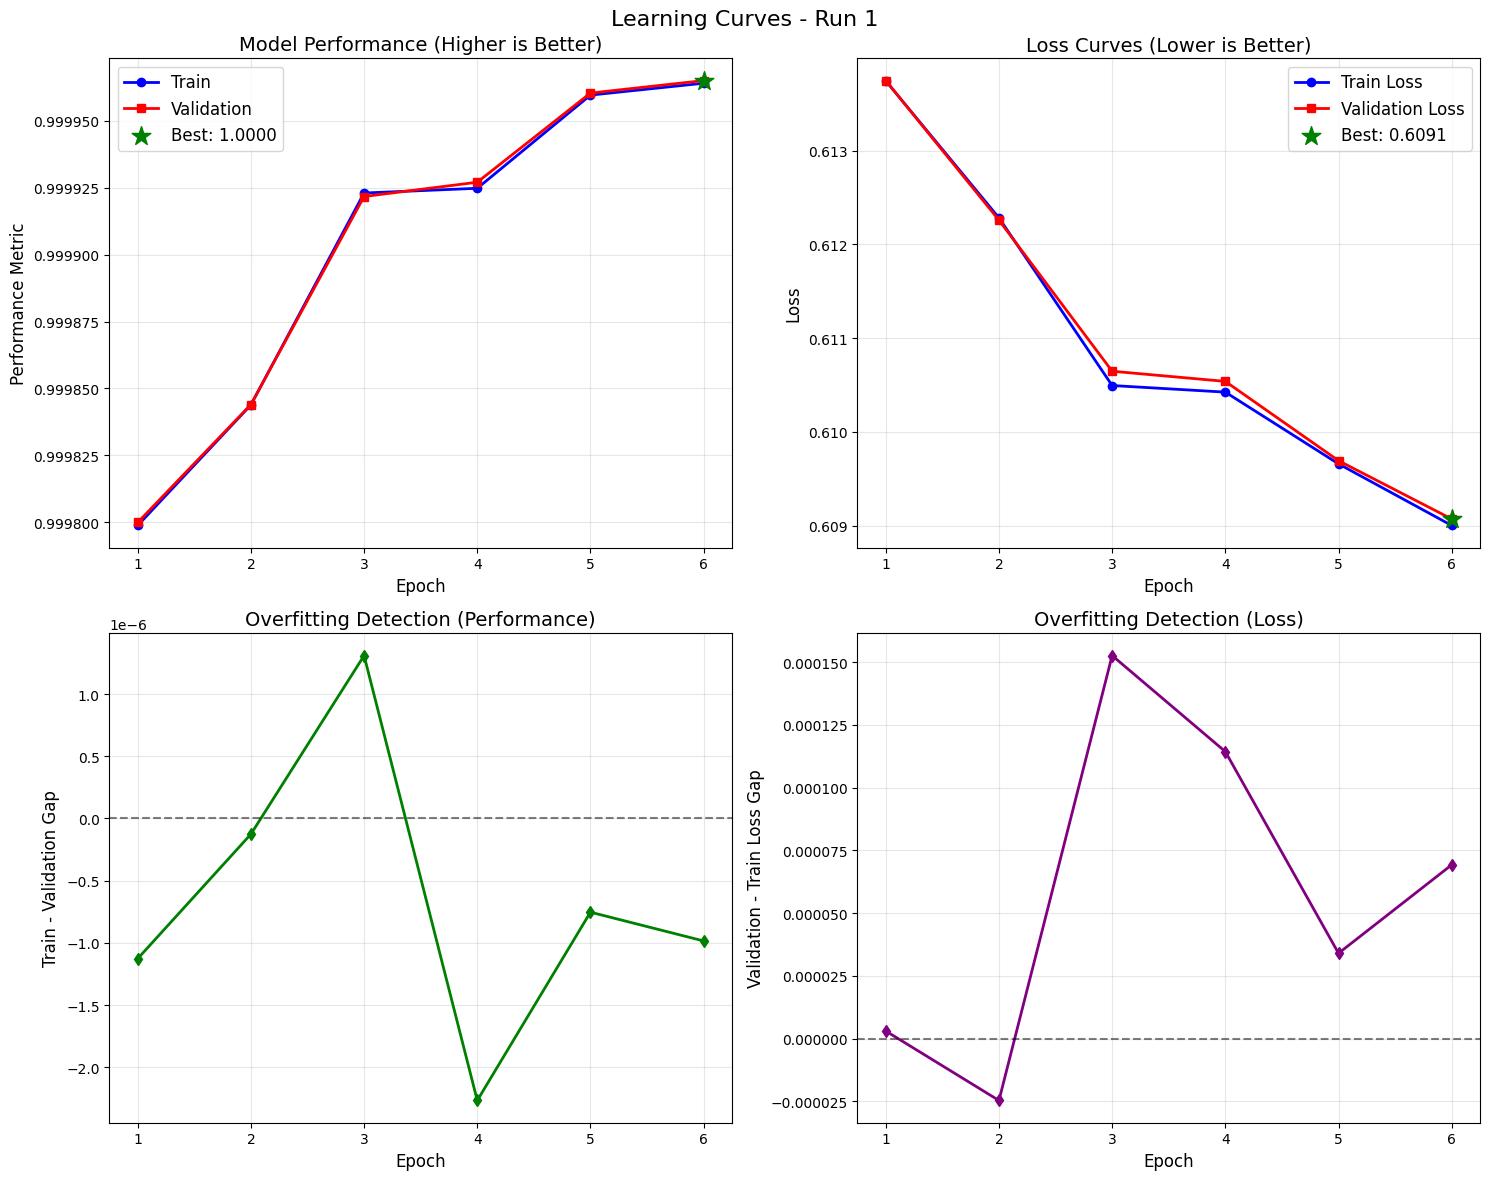

start testing!...
NDCG: 1.0000
test-result = 1.0000, test-logloss = 0.6090
test_auc [np.float64(0.9999647156165803)]
test_log_loss [np.float64(0.6090415404021262)]
avg_auc 0.9999647156165803
avg_log_loss 0.6090415404021262


In [135]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Î™ÖÎ†πÌñâ Ïù∏Ïûê ÌååÏã±
# args = parse_args()
print(args.__dict__) # Î™®Îì† Ïù∏Ïûê Ï∂úÎ†•
print('**************')

# Îç∞Ïù¥ÌÑ∞ÏÖãÎ≥Ñ ÌååÏùº Ïù¥Î¶Ñ ÏÑ§Ï†ï
# if args.data in ['Avazu']:
#     # AvazuÎäî ÏàòÏπòÌòï ÌäπÏÑ±Ïù¥ ÏóÜÏñ¥ÏÑú Ïä§ÏºÄÏùºÎßÅÌïòÏßÄ ÏïäÏùå
#     file_name = ['train_i.npy', 'train_x.npy', 'train_y.npy']
# elif args.data in ['Criteo', 'KDD2012']:
#     # CriteoÏôÄ KDD2012Îäî Ïä§ÏºÄÏùºÎßÅÎêú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö© (train_x2.npy)
file_name = ['train_i.npy', 'train_x2.npy', 'train_y.npy']

# Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
test_auc = [] # AUC Ï†êÏàòÎì§
test_log = [] # log lossÎì§

# Ïó¨Îü¨ Ïã§Ìñâ Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
all_models = []

print('run time : %d' % args.run_times)

# Ïó¨Îü¨ Î≤à Ïã§ÌñâÌïòÏó¨ ÌèâÍ∑† ÏÑ±Îä• Í≥ÑÏÇ∞ (Ïã§ÌóòÏùò Ïã†Î¢∞ÏÑ± Ìñ•ÏÉÅ)
for i in range(1, args.run_times + 1):
    test_result, test_loss, model = _run_(args, file_name, i)
    test_auc.append(test_result)
    test_log.append(test_loss)

    # Î™®Îç∏ Ï†ÄÏû• (ÎÇòÏ§ëÏóê ÎπÑÍµêÎ•º ÏúÑÌï¥)
    if args.run_times > 1:
        all_models.append(model)  # Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ Ï†ÄÏû•

# ÏµúÏ¢Ö Í≤∞Í≥º Ï∂úÎ†•
print('test_auc', test_auc)
print('test_log_loss', test_log)
print('avg_auc', sum(test_auc)/len(test_auc)) # ÌèâÍ∑† AUC
print('avg_log_loss', sum(test_log)/len(test_log)) # ÌèâÍ∑† log loss

# Ïó¨Îü¨ Ïã§Ìñâ Í≤∞Í≥º ÎπÑÍµê (run_times > 1Ïù∏ Í≤ΩÏö∞)
if args.run_times > 1 and all_models:
    compare_multiple_runs(all_models)

In [140]:
# ÏòàÏ∏°Í∞í Î∂ÑÌè¨ ÌôïÏù∏
Xi_test = np.load(config.DATA_PATH + '/part1/' + file_name[0])
Xv_test = np.load(config.DATA_PATH + '/part1/' + file_name[1])
y_pred = model.predict(Xi_test, Xv_test)
print("Prediction stats:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")
print(f"Mean: {y_pred.mean():.4f}, Std: {y_pred.std():.4f}")
print("\nPrediction distribution:")
print(np.histogram(y_pred, bins=10))

Prediction stats:
Min: 0.0671, Max: 0.9918
Mean: 0.5809, Std: 0.1769

Prediction distribution:
(array([  3936,  62684,  17264, 312818,  31659, 583431,  82627, 134521,
       112891,  58169]), array([0.06705153, 0.15952708, 0.25200263, 0.3444782 , 0.43695372,
       0.52942926, 0.62190485, 0.7143804 , 0.8068559 , 0.89933145,
       0.99180704], dtype=float32))


# Ïã§Ï†ú Ï∂îÏ≤ú

In [144]:
# recommendation_with_autoint.py
"""
AutoInt Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìïú ÏùòÏûê Ï∂îÏ≤ú ÏãúÏä§ÌÖú
"""

import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from argparse import Namespace

# Ï†úÍ≥µÎêú ÏΩîÎìúÏùò ÌÅ¥ÎûòÏä§Îì§
# from paste import DataPreprocessor
# from paste_4 import AutoInt
# from paste_3 import LearningCurveVisualizer

def load_test_data_and_chairs():
    """ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏôÄ ÏùòÏûê Îç∞Ïù¥ÌÑ∞ Î°úÎìú"""
    # Person ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    person_test_df = pd.read_excel('person_test.xlsx', engine='openpyxl')
    
    # cm -> mm Î≥ÄÌôò
    person_features = [
        'human-height', 'A_Buttock-popliteal length',
        'B_Popliteal-height', 'C_Hip-breadth',
        'F_Sitting-height', 'G_Shoulder-breadth'
    ]
    
    for col in person_features:
        if col in person_test_df.columns:
            person_test_df[col] *= 10
    
    # Chair Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    chair_df = pd.read_excel('chair_dummy.xlsx', engine='openpyxl')
    
    # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î°úÎìú
    with open('processed_data/metadata.json', 'r') as f:
        metadata = json.load(f)
    
    return person_test_df, chair_df, metadata

def calculate_interaction_features(person_row, chair_row):
    """ÏÉÅÌò∏ÏûëÏö© ÌîºÏ≤ò Í≥ÑÏÇ∞ (DataPreprocessorÏóêÏÑú Í∞ÄÏ†∏Ïò¥)"""
    def safe_divide(numerator, denominator, default=0.0):
        if denominator > 0:
            return numerator / denominator
        return default
    
    features = {}
    
    # ÎÜíÏù¥ Ï†ÅÌï©ÎèÑ
    h8_mid = (chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] + chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']) / 2
    h8_range = chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX'] - chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']
    popliteal_height = person_row['B_Popliteal-height']
    
    if h8_range > 0:
        if chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] <= popliteal_height <= chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']:
            features['height_match_score'] = 1.0
        else:
            if popliteal_height < chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']:
                dist = chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN'] - popliteal_height
            else:
                dist = popliteal_height - chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']
            features['height_match_score'] = max(0, 1 - dist / 100)
    else:
        features['height_match_score'] = max(0, 1 - abs(h8_mid - popliteal_height) / 50)
    
    # Í∏∞ÌÉÄ ÌîºÏ≤òÎì§
    features['width_margin_ratio'] = safe_divide(
        chair_row['b3_Ï¢åÏÑù Í∞ÄÎ°ú Í∏∏Ïù¥'] - person_row['C_Hip-breadth'], 
        person_row['C_Hip-breadth']
    )
    features['depth_margin_ratio'] = safe_divide(
        person_row['A_Buttock-popliteal length'] - chair_row['t4_Ï¢åÏÑù ÏÑ∏Î°ú Í∏∏Ïù¥ ÏùºÎ∞ò'], 
        person_row['A_Buttock-popliteal length']
    )
    features['backrest_height_ratio'] = safe_divide(
        chair_row['h7_Îì±Î∞õÏù¥ ÏÑ∏Î°ú Í∏∏Ïù¥'], 
        person_row['F_Sitting-height']
    )
    features['shoulder_width_ratio'] = safe_divide(
        chair_row['b4_Îì±Î∞õÏù¥ Í∞ÄÎ°ú Í∏∏Ïù¥'], 
        person_row['G_Shoulder-breadth']
    )
    features['adjustable_range'] = h8_range
    
    return features

def create_feature_vectors(person_row, chair_row, metadata):
    """ÌîºÏ≤ò Î≤°ÌÑ∞ ÏÉùÏÑ±"""
    values = []
    indices = []
    
    feature_idx_map = metadata['feature_mappings']
    person_features = metadata['person_features']
    numerical_features = metadata['chair_numerical_features']
    categorical_features = metadata['categorical_features']
    
    # 1. Person ÏàòÏπòÌòï ÌîºÏ≤ò
    for feat in person_features:
        if feat in person_row.index:
            values.append(str(person_row[feat]))
            indices.append(str(feature_idx_map[f'person_{feat}']))
    
    # 2. Chair ÏàòÏπòÌòï ÌîºÏ≤ò
    for feat in numerical_features:
        values.append(str(chair_row[feat]))
        indices.append(str(feature_idx_map[f'chair_{feat}']))
    
    # 3. ÏÉÅÌò∏ÏûëÏö© ÌîºÏ≤ò
    interaction_feats = calculate_interaction_features(person_row, chair_row)
    for feat_name, feat_value in interaction_feats.items():
        values.append(str(feat_value))
        indices.append(str(feature_idx_map[feat_name]))
    
    # 4. Ïù¥ÏßÑ Î≤îÏ£ºÌòï ÌîºÏ≤ò
    for feat in categorical_features:
        values.append('1')
        
        # Î≤îÏ£ºÌòï Í∞íÏùÑ 0/1Î°ú Î≥ÄÌôò
        if pd.isna(chair_row[feat]):
            feat_value = 0
        elif feat == 'Îì±Î∞õÏù¥ Í≥ß/Í∫æ':
            # 'Í≥ß'=0, 'Í∫æ'=1Î°ú Îß§Ìïë
            feat_value = 0 if chair_row[feat] == 'Í≥ß' else 1
        else:
            # 'O'=1, 'X'=0ÏúºÎ°ú Îß§Ìïë
            feat_value = 1 if chair_row[feat] == 'O' else 0
            
        idx_key = f'{feat}_{feat_value}'
        indices.append(str(feature_idx_map[idx_key]))
    
    return values, indices

def train_autoint_model():
    """AutoInt Î™®Îç∏ ÌïôÏäµ"""
    print("AutoInt Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...")
    
    # Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    Xi_list, Xv_list, y_list = [], [], []
    
    with open('processed_data/train_i.txt', 'r') as f_i, \
         open('processed_data/train_x.txt', 'r') as f_x, \
         open('processed_data/train_y.txt', 'r') as f_y:
        
        # Îπ†Î•∏ ÌÖåÏä§Ìä∏Î•º ÏúÑÌï¥ ÏùºÎ∂ÄÎßå ÏÇ¨Ïö©
        max_samples = 5000
        for i, (line_i, line_x, line_y) in enumerate(zip(f_i, f_x, f_y)):
            if i >= max_samples:
                break
            Xi_list.append([int(x) for x in line_i.strip().split()])
            Xv_list.append([float(x) for x in line_x.strip().split()])
            y_list.append(float(line_y.strip()))
    
    Xi = np.array(Xi_list)
    Xv = np.array(Xv_list)
    y = np.array(y_list)
    
    # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
    split_idx = int(len(y) * 0.8)
    Xi_train, Xi_valid = Xi[:split_idx], Xi[split_idx:]
    Xv_train, Xv_valid = Xv[:split_idx], Xv[split_idx:]
    y_train, y_valid = y[:split_idx], y[split_idx:]
    
    # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
    args = Namespace(
        is_save=True,
        greater_is_better=True,
        has_residual=True,
        blocks=2,
        block_shape=[16, 16],
        heads=2,
        embedding_size=16,
        dropout_keep_prob=[1.0, 1.0, 0.5],
        epoch=5,
        batch_size=512,
        learning_rate=0.001,
        optimizer_type='adam',
        l2_reg=0.0,
        random_seed=42,
        save_path='./autoint_model/',
        field_size=Xi.shape[1],
        loss_type='ranking_ndcg',
        verbose=1,
        run_times=1,
        deep_layers=None,
        batch_norm=0,
        batch_norm_decay=0.995
    )
    
    os.makedirs(args.save_path, exist_ok=True)
    
    # ÌäπÏÑ± ÌÅ¨Í∏∞
    feature_size = int(Xi.max() + 1)
    
    # Î™®Îç∏ ÏÉùÏÑ±
    model = AutoInt(args=args, feature_size=feature_size, run_cnt=1)
    
    # ÌïôÏäµ
    for epoch in range(args.epoch):
        print(f"\nEpoch {epoch+1}/{args.epoch}")
        model.fit_once(
            Xi_train, Xv_train, y_train,
            epoch+1, 1,
            Xi_valid, Xv_valid, y_valid,
            early_stopping=False
        )
    
    print(f"\nÌïôÏäµ ÏôÑÎ£å! ÏµúÏ¢Ö Í≤ÄÏ¶ù Ï†êÏàò: {model.valid_result[-1]:.4f}")
    
    return model

def recommend_chairs_for_users(model, person_test_df, chair_df, metadata):
    """Í∞Å ÏÇ¨Ïö©ÏûêÏóêÍ≤å ÏùòÏûê Ï∂îÏ≤ú"""
    recommendations = {}
    
    print("\nÏ∂îÏ≤ú ÏÉùÏÑ± Ï§ë...")
    
    for person_idx, person_row in person_test_df.iterrows():
        person_id = person_row.get('image-name', f'Person_{person_idx}')
        print(f"  - {person_id} Ï≤òÎ¶¨ Ï§ë...")
        
        # Í∞Å ÏùòÏûêÏóê ÎåÄÌïú Ï†êÏàò Í≥ÑÏÇ∞
        chair_scores = []
        
        for chair_idx, chair_row in chair_df.iterrows():
            # ÌîºÏ≤ò Î≤°ÌÑ∞ ÏÉùÏÑ±
            values, indices = create_feature_vectors(person_row, chair_row, metadata)
            
            # Î™®Îç∏ ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
            Xi = np.array([[int(idx) for idx in indices]])
            Xv = np.array([[float(val) for val in values]])
            
            # ÏòàÏ∏°
            score = model.predict(Xi, Xv)[0]
            
            # ÏùòÏûê Ï†ïÎ≥¥ Ï†ÄÏû•
            chair_info = {
                'chair_idx': chair_idx,
                'chair_name': f'Chair_{chair_idx}',  # Ïã§Ï†ú ÏùòÏûê Ïù¥Î¶ÑÏù¥ ÏûàÎã§Î©¥ ÏÇ¨Ïö©
                'score': float(score),
                'specs': {
                    'height_range': f"{chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MIN']}-{chair_row['h8_ÏßÄÎ©¥-Ï¢åÏÑù ÎÜíÏù¥_MAX']}mm",
                    'seat_width': f"{chair_row['b3_Ï¢åÏÑù Í∞ÄÎ°ú Í∏∏Ïù¥']}mm",
                    'seat_depth': f"{chair_row['t4_Ï¢åÏÑù ÏÑ∏Î°ú Í∏∏Ïù¥ ÏùºÎ∞ò']}mm",
                    'backrest_height': f"{chair_row['h7_Îì±Î∞õÏù¥ ÏÑ∏Î°ú Í∏∏Ïù¥']}mm",
                    'backrest_width': f"{chair_row['b4_Îì±Î∞õÏù¥ Í∞ÄÎ°ú Í∏∏Ïù¥']}mm"
                }
            }
            chair_scores.append(chair_info)
        
        # Ï†êÏàò Í∏∞Ï§Ä Ï†ïÎ†¨
        chair_scores.sort(key=lambda x: x['score'], reverse=True)
        
        # Top-5 ÏÑ†ÌÉù
        recommendations[person_id] = {
            'person_specs': {
                'height': f"{person_row['human-height']/10:.1f}cm",
                'popliteal_height': f"{person_row['B_Popliteal-height']/10:.1f}cm",
                'hip_breadth': f"{person_row['C_Hip-breadth']/10:.1f}cm",
                'sitting_height': f"{person_row['F_Sitting-height']/10:.1f}cm",
                'shoulder_breadth': f"{person_row['G_Shoulder-breadth']/10:.1f}cm"
            },
            'top_5_chairs': chair_scores[:5]
        }
    
    return recommendations

def display_recommendations(recommendations):
    """Ï∂îÏ≤ú Í≤∞Í≥º Ï∂úÎ†•"""
    print("\n" + "="*80)
    print("ü™ë ÏùòÏûê Ï∂îÏ≤ú Í≤∞Í≥º")
    print("="*80)
    
    for person_id, rec_data in recommendations.items():
        print(f"\nüë§ {person_id}")
        print(f"üìè Ïã†Ï≤¥ Ï†ïÎ≥¥: {', '.join([f'{k}={v}' for k, v in rec_data['person_specs'].items()])}")
        print(f"\nüéØ Top-5 Ï∂îÏ≤ú ÏùòÏûê:")
        
        for i, chair in enumerate(rec_data['top_5_chairs'], 1):
            print(f"\n  {i}. {chair['chair_name']} (Ï†êÏàò: {chair['score']:.4f})")
            print(f"     ÌÅ¨Í∏∞: {chair['specs']['seat_width']} x {chair['specs']['seat_depth']}")
            print(f"     ÎÜíÏù¥: {chair['specs']['height_range']}")
            print(f"     Îì±Î∞õÏù¥: {chair['specs']['backrest_height']} x {chair['specs']['backrest_width']}")

def save_recommendations(recommendations):
    """Ï∂îÏ≤ú Í≤∞Í≥º Ï†ÄÏû•"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # JSON Ï†ÄÏû•
    json_path = f'chair_recommendations_{timestamp}.json'
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(recommendations, f, ensure_ascii=False, indent=2)
    print(f"\nüíæ JSON Ï†ÄÏû•: {json_path}")
    
    # CSV Ï†ÄÏû•
    csv_data = []
    for person_id, rec_data in recommendations.items():
        for rank, chair in enumerate(rec_data['top_5_chairs'], 1):
            csv_data.append({
                'Person_ID': person_id,
                'Person_Height': rec_data['person_specs']['height'],
                'Rank': rank,
                'Chair_Name': chair['chair_name'],
                'Score': chair['score'],
                'Height_Range': chair['specs']['height_range'],
                'Seat_Size': f"{chair['specs']['seat_width']} x {chair['specs']['seat_depth']}"
            })
    
    csv_df = pd.DataFrame(csv_data)
    csv_path = f'chair_recommendations_{timestamp}.csv'
    csv_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"üìä CSV Ï†ÄÏû•: {csv_path}")

def main():
    """Î©îÏù∏ Ïã§Ìñâ Ìï®Ïàò"""
    print("üöÄ AutoInt Í∏∞Î∞ò ÏùòÏûê Ï∂îÏ≤ú ÏãúÏä§ÌÖú")
    print("="*80)
    
    # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    print("\n[1/4] Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...")
    person_test_df, chair_df, metadata = load_test_data_and_chairs()
    print(f"  - ÌÖåÏä§Ìä∏ ÏÇ¨Ïö©Ïûê Ïàò: {len(person_test_df)}")
    print(f"  - ÏùòÏûê Ïàò: {len(chair_df)}")
    
    # 2. Î™®Îç∏ ÌïôÏäµ ÎòêÎäî Î°úÎìú
    print("\n[2/4] Î™®Îç∏ Ï§ÄÎπÑ Ï§ë...")
    model_path = './autoint_model/'
    
    if os.path.exists(model_path + '1/'):
        # Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú
        print("  - Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú Ï§ë...")
        # Î™®Îç∏ ÏÑ§Ï†ï
        args = Namespace(
            is_save=False,
            greater_is_better=True,
            has_residual=True,
            blocks=2,
            block_shape=[16, 16],
            heads=2,
            embedding_size=16,
            dropout_keep_prob=[1.0, 1.0, 1.0],
            epoch=0,
            batch_size=512,
            learning_rate=0.001,
            optimizer_type='adam',
            l2_reg=0.0,
            random_seed=42,
            save_path='./autoint_model/',
            field_size=metadata['numerical_features'] + len(metadata['categorical_features']),
            loss_type='ranking_ndcg',
            verbose=0,
            run_times=1,
            deep_layers=None,
            batch_norm=0,
            batch_norm_decay=0.995
        )
        
        feature_size = metadata['total_features']
        model = AutoInt(args=args, feature_size=feature_size, run_cnt=1)
        model.restore()
    else:
        # ÏÉàÎ°ú ÌïôÏäµ
        print("  - ÏÉàÎ°úÏö¥ Î™®Îç∏ ÌïôÏäµ Ï§ë...")
        model = train_autoint_model()
    
    # 3. Ï∂îÏ≤ú ÏÉùÏÑ±
    print("\n[3/4] Ï∂îÏ≤ú ÏÉùÏÑ± Ï§ë...")
    recommendations = recommend_chairs_for_users(model, person_test_df, chair_df, metadata)
    
    # 4. Í≤∞Í≥º Ï∂úÎ†• Î∞è Ï†ÄÏû•
    print("\n[4/4] Í≤∞Í≥º Ï≤òÎ¶¨ Ï§ë...")
    display_recommendations(recommendations)
    save_recommendations(recommendations)
    
    print("\n‚úÖ ÏôÑÎ£å!")
    return recommendations

# if __name__ == "__main__":
#     # TensorFlow Î°úÍ∑∏ Î†àÎ≤® ÏÑ§Ï†ï
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    
    # Ïã§Ìñâ
recommendations = main()

üöÄ AutoInt Í∏∞Î∞ò ÏùòÏûê Ï∂îÏ≤ú ÏãúÏä§ÌÖú

[1/4] Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...
  - ÌÖåÏä§Ìä∏ ÏÇ¨Ïö©Ïûê Ïàò: 4
  - ÏùòÏûê Ïàò: 1000000

[2/4] Î™®Îç∏ Ï§ÄÎπÑ Ï§ë...
  - ÏÉàÎ°úÏö¥ Î™®Îç∏ ÌïôÏäµ Ï§ë...
AutoInt Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...
total parameters :3121
extra parameters : 2625

Epoch 1/5
NDCG: 0.9467
NDCG: 0.9278
[1-1] model saved!. Valid loss is improved from 1.0000 to 0.6951
[1-1] train-result=0.9467, train-logloss=0.6950, valid-result=0.9278, valid-logloss=0.6951 [0.6 s]

Epoch 2/5
NDCG: 0.9532
NDCG: 0.9281
[2-1] model saved!. Valid loss is improved from 0.6951 to 0.6876
[2-1] train-result=0.9532, train-logloss=0.6852, valid-result=0.9281, valid-logloss=0.6876 [0.3 s]

Epoch 3/5
NDCG: 0.9534
NDCG: 0.9320
[3-1] train-result=0.9534, train-logloss=0.6852, valid-result=0.9320, valid-logloss=0.6879 [0.3 s]

Epoch 4/5
NDCG: 0.9648
NDCG: 0.9464
[4-1] model saved!. Valid loss is improved from 0.6876 to 0.6853
[4-1] train-result=0.9648, train-logloss=0.6833, valid-result=0.9464, valid-logloss=0.68